# Comprehensive Inflow Prediction Workflow with Kernel Methods

This notebook provides a complete workflow for hydrological inflow prediction using advanced kernel-based machine learning methods, following principles from Liu & Brutsaert (1978) and incorporating modern optimization techniques.


## 0. Imports and Utility Functions

Import all required libraries and define utility functions for hydrological metrics and evaluation.

In [1]:
# 0. Imports and Utility Functions
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import matplotlib.animation as animation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.svm import SVR, NuSVR, LinearSVR

# Hydrological Metrics
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Compute Nash-Sutcliffe Efficiency (NSE) for model evaluation.
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    if denominator == 0:
        return np.nan
    return 1 - (numerator / denominator)

def peak_error(observed, predicted):
    """
    Compute peak error (PE) as percent difference between observed and predicted peak.
    """
    max_observed = np.max(observed)
    max_predicted = np.max(predicted)
    epsilon = 1e-6
    if max_observed < epsilon:
        return np.nan
    return ((max_predicted - max_observed) / (max_observed + epsilon)) * 100

def total_peak_error(observed, predicted):
    """
    Compute total peak error (TPE) as percent difference between total observed and predicted inflow.
    """
    sum_observed = np.sum(observed)
    sum_predicted = np.sum(predicted)
    epsilon = 1e-6
    if sum_observed < epsilon:
        return np.nan
    return ((sum_predicted - sum_observed) / (sum_observed + epsilon)) * 100

def rmse(observed, predicted):
    """
    Compute Root Mean Squared Error (RMSE).
    """
    return np.sqrt(mean_squared_error(observed, predicted))

def kling_gupta_efficiency(observed, predicted):
    """
    Compute Kling-Gupta Efficiency (KGE).
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    r = np.corrcoef(observed, predicted)[0, 1]
    alpha = np.std(predicted) / np.std(observed)
    beta = np.mean(predicted) / np.mean(observed)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def calculate_all_metrics(observed, predicted, cv_score=None):
    """
    Calculate all hydrological metrics, plus explained variance (EVOL) and optional CV score.
    If cv_score is not provided, it will not be included in the output.
    """
    metrics = {
        'NSE': nash_sutcliffe_efficiency(observed, predicted),
        'PE': peak_error(observed, predicted),
        'TPE': total_peak_error(observed, predicted),
        'RMSE': rmse(observed, predicted),
        'R2': r2_score(observed, predicted),
        'KGE': kling_gupta_efficiency(observed, predicted),
        'EVOL': explained_variance_score(observed, predicted)
    }
    if cv_score is not None:
        metrics['CV_Score'] = cv_score
    return metrics

## 1. Data Loading and Feature Engineering

Load the dataset, detect rainfall columns, perform feature engineering (including lag features and cyclical date encoding), and split into train/test sets. Also, scale features for model training.

In [5]:
import numpy as np
import pandas as pd

# --- Data Loading ---
print("🔄 Loading data...")
data = pd.read_csv('Data.csv')
print("Data loaded successfully!")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# --- Rainfall Columns Detection ---
rainfall_columns = [col for col in data.columns if col.startswith('L')]
target_column = 'Inflow (cumecs)'
print(f"Detected {len(rainfall_columns)} rainfall locations")

# --- Feature Engineering ---
print("🔄 Starting comprehensive feature engineering...")
original_shape = data.shape
missing_before = data.isnull().sum().sum()
zero_rainfall_before = (data[rainfall_columns] == 0).sum().sum()

# Remove rows where inflow is 0 or missing
# data = data[data[target_column] > 1].copy()

# Replace zeros in target column with small value (0.01)
data[target_column] = data[target_column].replace(0, 0.01)

# Replace zeros in rainfall columns with small value (0.01)
for col in rainfall_columns:
    data[col] = data[col].replace(0, 0.01)

# Feature engineering: mean rainfall and inflow lags
data['mean_rainfall'] = data[rainfall_columns].mean(axis=1)
lag_list = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60]
for lag in lag_list:
    data[f'inflow_lag_{lag}'] = data[target_column].shift(lag)

# Date features (cyclical encoding)
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='raise')
data['day_of_year'] = data['Date'].dt.dayofyear
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 366)
data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 366)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

# Drop rows with NaN (from lags)
data = data.dropna().reset_index(drop=True)

missing_after = data.isnull().sum().sum()
zero_rainfall_after = (data[rainfall_columns] == 0).sum().sum()

print("Starting feature preparation pipeline...")
print(f"Original data shape: {original_shape}")
print(f"Missing values before processing: {missing_before}")
print(f"Zero values in rainfall columns: {zero_rainfall_before}")
print(f"Missing values after processing: {missing_after}")
print(f"Zero values after processing: {zero_rainfall_after}")

# --- Feature Columns ---
feature_names = (
    ['mean_rainfall'] +
    [f'inflow_lag_{lag}' for lag in lag_list] +
    ['day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
)
print("Feature preparation completed! Features:", feature_names)
print("✅ Feature engineering completed!")
print(f"Original features: {len(rainfall_columns)}")
print(f"Engineered features: {len(feature_names)}")
print(f"Feature names: {feature_names[:9]}...")

# --- Train/Test Split ---
split_index = int(0.8 * len(data))
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

X_train = train_data[feature_names]
y_train = train_data[target_column]
X_test = test_data[feature_names]
y_test = test_data[target_column]

# Show train/test date ranges
print(f"📅 Training data: {train_data['Date'].iloc[0].date()} to {train_data['Date'].iloc[-1].date()}")
print(f"📅 Testing data: {test_data['Date'].iloc[0].date()} to {test_data['Date'].iloc[-1].date()}")

# --- Scaling ---
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using RobustScaler")
print("✅ Data preprocessing completed!")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")
print(f"Features used: {X_train_scaled.shape[1]}")

🔄 Loading data...
Data loaded successfully!
Shape: (1830, 160)
Columns: ['Date', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20', 'L21', 'L22', 'L23', 'L24', 'L25', 'L26', 'L27', 'L28', 'L29', 'L30', 'L31', 'L32', 'L33', 'L34', 'L35', 'L36', 'L37', 'L38', 'L39', 'L40', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47', 'L48', 'L49', 'L50', 'L51', 'L52', 'L53', 'L54', 'L55', 'L56', 'L57', 'L58', 'L59', 'L60', 'L61', 'L62', 'L63', 'L64', 'L65', 'L66', 'L67', 'L68', 'L69', 'L70', 'L71', 'L72', 'L73', 'L74', 'L75', 'L76', 'L77', 'L78', 'L79', 'L80', 'L81', 'L82', 'L83', 'L84', 'L85', 'L86', 'L87', 'L88', 'L89', 'L90', 'L91', 'L92', 'L93', 'L94', 'L95', 'L96', 'L97', 'L98', 'L99', 'L100', 'L101', 'L102', 'L103', 'L104', 'L105', 'L106', 'L107', 'L108', 'L109', 'L110', 'L111', 'L112', 'L113', 'L114', 'L115', 'L116', 'L117', 'L118', 'L119', 'L120', 'L121', 'L122', 'L123', 'L124', 'L125', 'L126', 'L127', 'L128', 'L1

## 2. Data Distribution and Scaling Effect

Visualize the distribution of features before scaling and check for outliers.

<Figure size 1500x800 with 0 Axes>

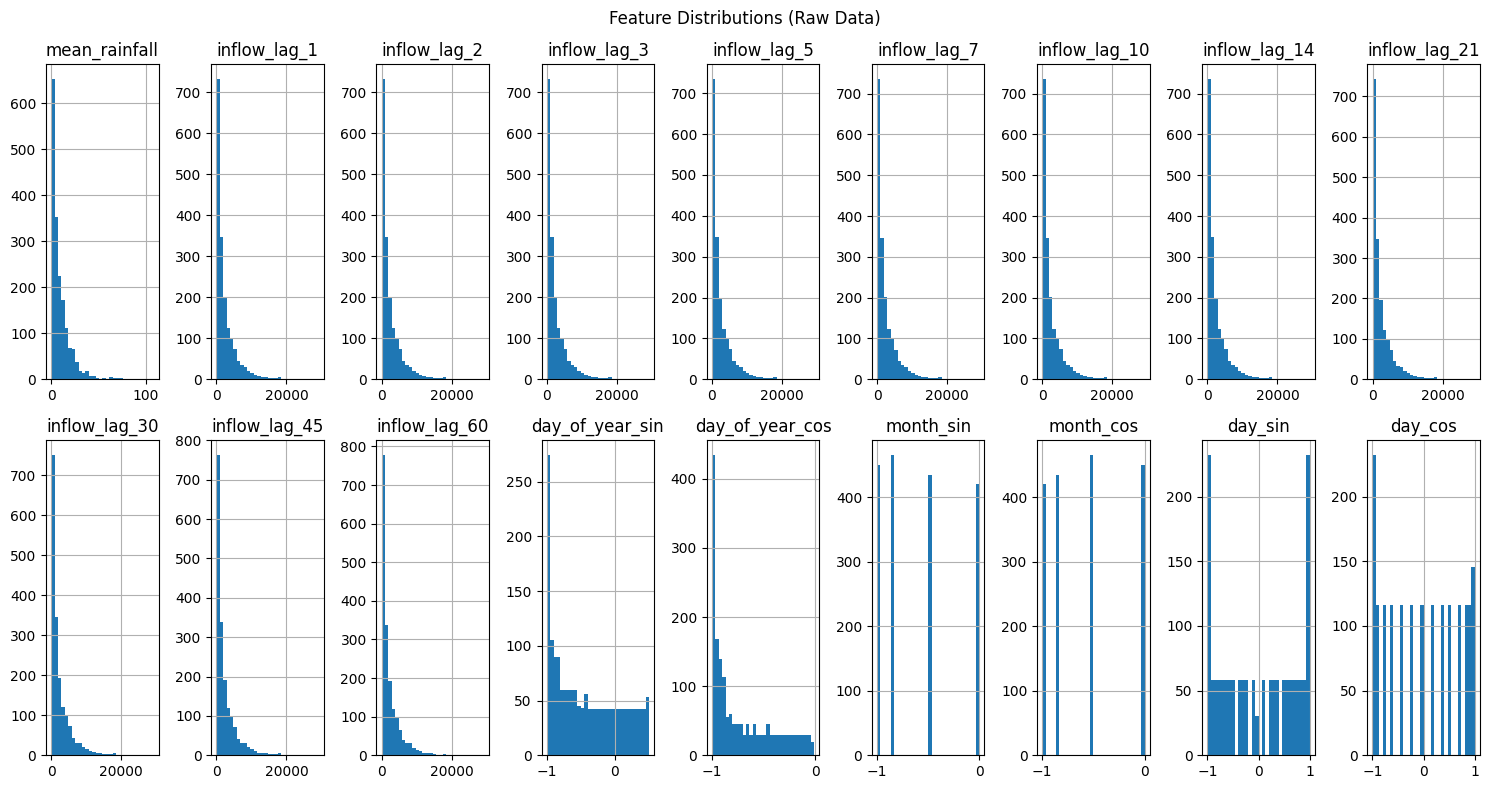

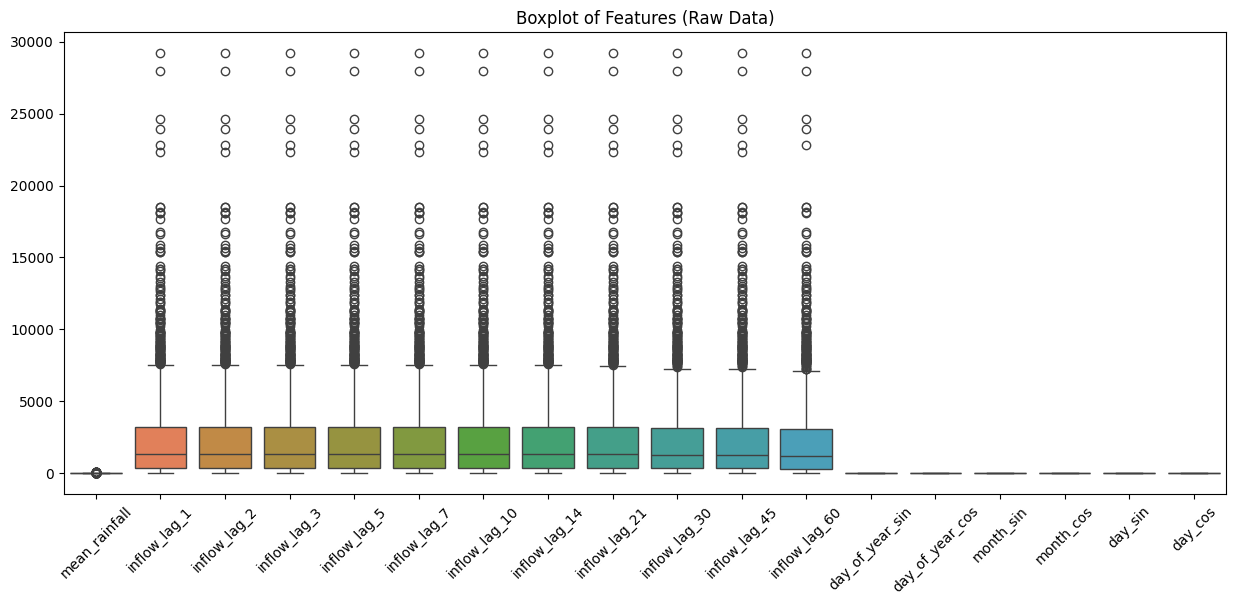

                  count          mean          std       min         25%  \
mean_rainfall    1770.0  9.293023e+00    10.851641  0.010000    2.023705   
inflow_lag_1     1770.0  2.424931e+03  3170.113921  0.010000  375.502250   
inflow_lag_2     1770.0  2.425141e+03  3170.059753  0.010000  375.502250   
inflow_lag_3     1770.0  2.424939e+03  3170.110595  0.010000  375.502250   
inflow_lag_5     1770.0  2.423497e+03  3170.590950  0.010000  375.502250   
inflow_lag_7     1770.0  2.420502e+03  3170.015228  0.010000  375.502250   
inflow_lag_10    1770.0  2.422841e+03  3170.848978  0.010000  375.502250   
inflow_lag_14    1770.0  2.422609e+03  3171.101209  0.010000  375.502250   
inflow_lag_21    1770.0  2.408770e+03  3169.615370  0.010000  371.728000   
inflow_lag_30    1770.0  2.386896e+03  3165.336837  0.010000  360.641250   
inflow_lag_45    1770.0  2.377447e+03  3168.878716  0.010000  347.571500   
inflow_lag_60    1770.0  2.299854e+03  3071.388698  0.010000  320.023000   
day_of_year_

In [3]:
# Check data distribution and scaling effect

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for all features
X_all = pd.concat([X_train, X_test])
plt.figure(figsize=(15, 8))
X_all.hist(bins=30, figsize=(15, 8), layout=(2, int(np.ceil(X_all.shape[1]/2))))
plt.suptitle("Feature Distributions (Raw Data)")
plt.tight_layout()
plt.show()

# Check for outliers using boxplots
plt.figure(figsize=(15, 6))
sns.boxplot(data=X_all)
plt.title("Boxplot of Features (Raw Data)")
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print(X_all.describe().T)

## 3. Model Training and Hyperparameter Optimization

Train and optimize various regression models (SVR, GP, KRR, RF, Ridge, Bayesian Ridge, DecisionTree, ElasticNet, Nadaraya-Watson, KNN, HistGradientBoosting, Polynomial, ExtraTrees, LightGBM, XGBoost, CatBoost) using Optuna for hyperparameter tuning. Each model cell is commented for clarity.

In [ ]:
# 2. Support Vector Regression (SVR)

from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
import optuna

# SVR Objective Function for Optuna
def svr_objective(trial):
    svr_type = trial.suggest_categorical('svr_type', ['SVR', 'NuSVR', 'LinearSVR'])
    kernel = trial.suggest_categorical(
        'kernel',
        ['rbf', 'linear', 'poly', 'sigmoid']
    )
    if svr_type == 'SVR':
        C = trial.suggest_float('C', 0.01, 200, log=True)
        epsilon = trial.suggest_float('epsilon', 0.00001, 5.0, log=True)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        shrinking = trial.suggest_categorical('shrinking', [True, False])
        cache_size = trial.suggest_int('cache_size', 200, 4000, step=200)
        verbose = trial.suggest_categorical('verbose', [False, True])
        max_iter = trial.suggest_int('max_iter', 1000, 20000, step=1000)
        params = dict(kernel=kernel, C=C, epsilon=epsilon, tol=tol, shrinking=shrinking, cache_size=cache_size, verbose=verbose, max_iter=max_iter)
        if kernel in ['rbf', 'poly', 'sigmoid']:
            params['gamma'] = trial.suggest_float('gamma', 1e-7, 1e-1, log=True)
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 8)
            params['coef0'] = trial.suggest_float('coef0', 0.0, 5.0)
        if kernel == 'sigmoid':
            params['coef0'] = trial.suggest_float('coef0', 0.0, 5.0)
        model = SVR(**params)
    elif svr_type == 'NuSVR':
        nu = trial.suggest_float('nu', 0.01, 0.99)
        C = trial.suggest_float('C', 0.01, 200, log=True)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        cache_size = trial.suggest_int('cache_size', 200, 4000, step=200)
        verbose = trial.suggest_categorical('verbose', [False, True])
        max_iter = trial.suggest_int('max_iter', 1000, 20000, step=1000)
        params = dict(kernel=kernel, nu=nu, C=C, tol=tol, cache_size=cache_size, verbose=verbose, max_iter=max_iter)
        if kernel in ['rbf', 'poly', 'sigmoid']:
            params['gamma'] = trial.suggest_float('gamma', 1e-7, 1e-1, log=True)
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 8)
            params['coef0'] = trial.suggest_float('coef0', 0.0, 5.0)
        if kernel == 'sigmoid':
            params['coef0'] = trial.suggest_float('coef0', 0.0, 5.0)
        model = NuSVR(**params)
    else:  # LinearSVR
        C = trial.suggest_float('C', 0.01, 200, log=True)
        epsilon = trial.suggest_float('epsilon', 0.00001, 5.0, log=True)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
        dual = trial.suggest_categorical('dual', [True, False])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        max_iter = trial.suggest_int('max_iter', 1000, 20000, step=1000)
        # Only allow dual=True when loss='epsilon_insensitive'
        if loss == 'epsilon_insensitive' and not dual:
            import optuna
            raise optuna.TrialPruned()
        model = LinearSVR(C=C, epsilon=epsilon, tol=tol, loss=loss, dual=dual, fit_intercept=fit_intercept, max_iter=max_iter)

    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=6)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
    return np.nanmean(scores)
#
# Hyperparameter tuning study for SVR
study_svr = optuna.create_study(direction='maximize')
study_svr.optimize(svr_objective, n_trials=150)
best_svr_params = study_svr.best_params
print("Best SVR Params:", best_svr_params)

# Build the best SVR-like model
if best_svr_params['svr_type'] == 'SVR':
    svr_model = SVR(
        kernel=best_svr_params['kernel'],
        C=best_svr_params['C'],
        epsilon=best_svr_params['epsilon'],
        tol=best_svr_params['tol'],
        shrinking=best_svr_params.get('shrinking', True),
        cache_size=best_svr_params.get('cache_size', 200),
        gamma=best_svr_params.get('gamma', 'scale'),
        degree=best_svr_params.get('degree', 3),
        coef0=best_svr_params.get('coef0', 0.0),
        verbose=best_svr_params.get('verbose', False),
        max_iter=best_svr_params.get('max_iter', 10000)
    )
elif best_svr_params['svr_type'] == 'NuSVR':
    svr_model = NuSVR(
        kernel=best_svr_params['kernel'],
        nu=best_svr_params['nu'],
        C=best_svr_params['C'],
        tol=best_svr_params['tol'],
        cache_size=best_svr_params.get('cache_size', 200),
        gamma=best_svr_params.get('gamma', 'scale'),
        degree=best_svr_params.get('degree', 3),
        coef0=best_svr_params.get('coef0', 0.0),
        verbose=best_svr_params.get('verbose', False),
        max_iter=best_svr_params.get('max_iter', 10000)
    )
else:
    svr_model = LinearSVR(
        C=best_svr_params['C'],
        epsilon=best_svr_params['epsilon'],
        tol=best_svr_params['tol'],
        loss=best_svr_params['loss'],
        dual=best_svr_params['dual'],
        fit_intercept=best_svr_params['fit_intercept'],
        max_iter=best_svr_params['max_iter']
    )

# Stacking with more advanced regressors for ensemble
base_learners = [
    ('svr', svr_model),
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.1)),
    ('enet', ElasticNet(alpha=0.1, l1_ratio=0.7)),
    ('rf', RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, learning_rate=0.02, max_depth=6, random_state=42)),
    ('etr', ExtraTreesRegressor(n_estimators=120, max_depth=12, random_state=42)),
    ('ada', AdaBoostRegressor(n_estimators=120, learning_rate=0.03, random_state=42)),
    ('bayridge', BayesianRidge()),
    ('huber', HuberRegressor(epsilon=1.35)),
    ('bag', BaggingRegressor(n_estimators=50, random_state=42))
]
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge(alpha=0.2),
    passthrough=True,
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train)
y_pred_stack = stacking_model.predict(X_test_scaled)

metrics_stack = calculate_all_metrics(y_test, y_pred_stack)
print("Stacked Model Metrics:", metrics_stack)

### SVR Metrics

Evaluate the best SVR-like model on the test set and store metrics.

In [ ]:
# 2B. SVR Metrics

# Fit the best SVR-like model on the training set (required if not already fitted)
svr_model.fit(X_train_scaled, y_train)

# Display which model and kernel is used, and the other params
print("SVR Model Type:", best_svr_params['svr_type'])
if best_svr_params['svr_type'] in ['SVR', 'NuSVR']:
    print("Kernel:", best_svr_params['kernel'])
for k, v in best_svr_params.items():
    print(f"{k}: {v}")

# Predict using the best SVR-like model on the test set
y_pred_svr = svr_model.predict(X_test_scaled)

# Calculate and print metrics, including CV score
metrics_svr = calculate_all_metrics(y_test, y_pred_svr, cv_score=study_svr.best_value)
print("SVR Metrics:", metrics_svr)

# Store the results for the SVR model
if 'model_results' not in globals():
    model_results = {}
model_results['SVR'] = metrics_svr

### Save SVR Model

Persist the trained SVR model for future use.

In [ ]:
# 2C. Save SVR Model

joblib.dump(svr_model, "svr_model.pkl")
print("SVR model saved as svr_model.pkl")

### Gaussian Process Regression (GP) - Hyperparameter Tuning & Training

Train a Gaussian Process model with kernel search and evaluate.

In [ ]:
# 3. Gaussian Process Regression (GP) - Hyperparameter Tuning & Training

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared, DotProduct, ConstantKernel
)

def gp_objective(trial):
    kernel_type = trial.suggest_categorical(
        'kernel_type',
        ['rbf', 'matern', 'rational_quadratic', 'exp_sine_squared', 'dot_product', 'rbf+white', 'matern+white']
    )
    # Increase lower bound for alpha to avoid numerical issues
    alpha = trial.suggest_float('alpha', 1e-6, 1e-2, log=True)
    length_scale = trial.suggest_float('length_scale', 0.1, 10.0)
    kernel = None

    if kernel_type == 'rbf':
        kernel = ConstantKernel() * RBF(length_scale=length_scale)
    elif kernel_type == 'matern':
        nu = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
        kernel = ConstantKernel() * Matern(length_scale=length_scale, nu=nu)
    elif kernel_type == 'rational_quadratic':
        alpha_rq = trial.suggest_float('alpha_rq', 0.01, 10.0, log=True)
        kernel = ConstantKernel() * RationalQuadratic(length_scale=length_scale, alpha=alpha_rq)
    elif kernel_type == 'exp_sine_squared':
        # Restrict periodicity to avoid instability
        periodicity = trial.suggest_float('periodicity', 1.0, 8.0)
        kernel = ConstantKernel() * ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    elif kernel_type == 'dot_product':
        sigma_0 = trial.suggest_float('sigma_0', 0.1, 5.0)
        kernel = ConstantKernel() * DotProduct(sigma_0=sigma_0)
    elif kernel_type == 'rbf+white':
        noise_level = trial.suggest_float('noise_level', 1e-6, 1e-2, log=True)
        kernel = ConstantKernel() * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    elif kernel_type == 'matern+white':
        nu = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
        noise_level = trial.suggest_float('noise_level', 1e-6, 1e-2, log=True)
        kernel = ConstantKernel() * Matern(length_scale=length_scale, nu=nu) + WhiteKernel(noise_level=noise_level)

    optimizer = trial.suggest_categorical('optimizer', ['fmin_l_bfgs_b', None])
    n_restarts_optimizer = trial.suggest_int('n_restarts_optimizer', 0, 3)
    normalize_y = trial.suggest_categorical('normalize_y', [True, False])

    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=alpha,
        optimizer=optimizer,
        n_restarts_optimizer=n_restarts_optimizer,
        normalize_y=normalize_y,
        random_state=42
    )
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    try:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring=nse_scorer, n_jobs=1)
        return np.nanmean(scores)
    except Exception:
        # Return a very poor score if the kernel fails
        return -9999

study_gp = optuna.create_study(direction='maximize')
study_gp.optimize(gp_objective, n_trials=40)
best_gp_params = study_gp.best_params
print("Best GP Params:", best_gp_params)

# Build the best kernel based on search
if best_gp_params['kernel_type'] == 'rbf':
    kernel = ConstantKernel() * RBF(length_scale=best_gp_params['length_scale'])
elif best_gp_params['kernel_type'] == 'matern':
    kernel = ConstantKernel() * Matern(length_scale=best_gp_params['length_scale'], nu=best_gp_params['nu'])
elif best_gp_params['kernel_type'] == 'rational_quadratic':
    kernel = ConstantKernel() * RationalQuadratic(length_scale=best_gp_params['length_scale'], alpha=best_gp_params['alpha_rq'])
elif best_gp_params['kernel_type'] == 'exp_sine_squared':
    kernel = ConstantKernel() * ExpSineSquared(length_scale=best_gp_params['length_scale'], periodicity=best_gp_params['periodicity'])
elif best_gp_params['kernel_type'] == 'dot_product':
    kernel = ConstantKernel() * DotProduct(sigma_0=best_gp_params['sigma_0'])
elif best_gp_params['kernel_type'] == 'rbf+white':
    kernel = ConstantKernel() * RBF(length_scale=best_gp_params['length_scale']) + WhiteKernel(noise_level=best_gp_params['noise_level'])
elif best_gp_params['kernel_type'] == 'matern+white':
    kernel = ConstantKernel() * Matern(length_scale=best_gp_params['length_scale'], nu=best_gp_params['nu']) + WhiteKernel(noise_level=best_gp_params['noise_level'])

gp_model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=best_gp_params['alpha'],
    optimizer=best_gp_params['optimizer'],
    n_restarts_optimizer=best_gp_params['n_restarts_optimizer'],
    normalize_y=best_gp_params['normalize_y'],
    random_state=42
)
gp_model.fit(X_train_scaled, y_train)
y_pred_gp, y_std_gp = gp_model.predict(X_test_scaled, return_std=True)

### GP Metrics

Evaluate the best GP model on the test set and store metrics.

In [ ]:
# 3B. GP Metrics

# Display which kernel and parameters are used for the best GP model
print("GP Kernel:", gp_model.kernel)
print("Best GP Params:")
for k, v in best_gp_params.items():
    print(f"{k}: {v}")

# Predict and calculate metrics
metrics_gp = calculate_all_metrics(y_test, y_pred_gp, cv_score=study_gp.best_value)
print("GP Metrics:", metrics_gp)

# Store the results for the GP model
if 'model_results' not in globals():
    model_results = {}
model_results['GP'] = metrics_gp

### Save GP Model

Persist the trained GP model for future use.

In [ ]:
# 3C. Save GP Model

joblib.dump(gp_model, "gp_model.pkl")
print("GP model saved as gp_model.pkl")

### Kernel Ridge Regression (KRR) - Hyperparameter Tuning & Training

Train a Kernel Ridge Regression model with kernel search and evaluate.

In [6]:
# 4. Kernel Ridge Regression (KRR) - Hyperparameter Tuning & Training

from sklearn.kernel_ridge import KernelRidge

def krr_objective(trial):
    # Only use kernels that support negative values
    kernel = trial.suggest_categorical(
        'kernel', ['rbf', 'linear', 'poly', 'laplacian', 'sigmoid']
    )
    alpha = trial.suggest_float('alpha', 1e-6, 30, log=True)
    if kernel == 'rbf':
        gamma = trial.suggest_float('gamma', 1e-6, 10, log=True)
        model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma)
    elif kernel == 'poly':
        gamma = trial.suggest_float('gamma', 1e-6, 10, log=True)
        degree = trial.suggest_int('degree', 2, 10)
        coef0 = trial.suggest_float('coef0', -5.0, 5.0)
        model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
    elif kernel == 'laplacian':
        gamma = trial.suggest_float('gamma', 1e-6, 10, log=True)
        model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma)
    elif kernel == 'sigmoid':
        gamma = trial.suggest_float('gamma', 1e-6, 10, log=True)
        coef0 = trial.suggest_float('coef0', -5.0, 5.0)
        model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, coef0=coef0)
    else:  # linear
        model = KernelRidge(kernel=kernel, alpha=alpha)
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=8)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
    return np.nanmean(scores)

study_krr = optuna.create_study(direction='maximize')
study_krr.optimize(krr_objective, n_trials=80)
best_krr_params = study_krr.best_params
print("Best KRR Params:", best_krr_params)

# Build the best model based on search
if best_krr_params['kernel'] == 'rbf':
    krr_model = KernelRidge(kernel='rbf', alpha=best_krr_params['alpha'], gamma=best_krr_params['gamma'])
elif best_krr_params['kernel'] == 'poly':
    krr_model = KernelRidge(
        kernel='poly',
        alpha=best_krr_params['alpha'],
        gamma=best_krr_params['gamma'],
        degree=best_krr_params['degree'],
        coef0=best_krr_params['coef0']
    )
elif best_krr_params['kernel'] == 'laplacian':
    krr_model = KernelRidge(kernel='laplacian', alpha=best_krr_params['alpha'], gamma=best_krr_params['gamma'])
elif best_krr_params['kernel'] == 'sigmoid':
    krr_model = KernelRidge(
        kernel='sigmoid',
        alpha=best_krr_params['alpha'],
        gamma=best_krr_params['gamma'],
        coef0=best_krr_params['coef0']
    )
else:
    krr_model = KernelRidge(kernel='linear', alpha=best_krr_params['alpha'])

krr_model.fit(X_train_scaled, y_train)
y_pred_krr = krr_model.predict(X_test_scaled)

[I 2025-07-17 04:37:43,523] A new study created in memory with name: no-name-963a818d-c2a0-4348-b998-0dc4932ad853


[I 2025-07-17 04:37:44,145] Trial 0 finished with value: 0.08807177074451815 and parameters: {'kernel': 'laplacian', 'alpha': 2.4101432128775238, 'gamma': 0.0005101038030337131}. Best is trial 0 with value: 0.08807177074451815.
[I 2025-07-17 04:37:44,696] Trial 1 finished with value: 0.6845255692212839 and parameters: {'kernel': 'linear', 'alpha': 11.550203250004792}. Best is trial 1 with value: 0.6845255692212839.
[I 2025-07-17 04:37:45,112] Trial 2 finished with value: 0.7002467144890536 and parameters: {'kernel': 'linear', 'alpha': 0.7946653196158069}. Best is trial 2 with value: 0.7002467144890536.
[I 2025-07-17 04:37:45,616] Trial 3 finished with value: 0.7341765635454361 and parameters: {'kernel': 'rbf', 'alpha': 0.11678228769082805, 'gamma': 0.00920060089162923}. Best is trial 3 with value: 0.7341765635454361.
[I 2025-07-17 04:37:49,280] Trial 4 finished with value: -0.40755682532624116 and parameters: {'kernel': 'sigmoid', 'alpha': 26.70012087432694, 'gamma': 0.0005069748074645

Best KRR Params: {'kernel': 'rbf', 'alpha': 0.029509922897437976, 'gamma': 0.001046956074163032}


### KRR Metrics

Evaluate the best KRR model on the test set and store metrics.

In [7]:
# 4B. KRR Metrics

# Display which kernel and parameters are used for the best KRR model
print("KRR Kernel:", krr_model.kernel)
print("Best KRR Params:")
for k, v in best_krr_params.items():
    print(f"{k}: {v}")

# Predict and calculate metrics
metrics_krr = calculate_all_metrics(y_test, y_pred_krr,cv_score=study_krr.best_value)
print("KRR Metrics:", metrics_krr)

# Store the results for the GP model
if 'model_results' not in globals():
    model_results = {}
model_results['KRR'] = metrics_krr

KRR Kernel: rbf
Best KRR Params:
kernel: rbf
alpha: 0.029509922897437976
gamma: 0.001046956074163032
KRR Metrics: {'NSE': np.float64(0.8420298022722301), 'PE': np.float64(-28.482366327529768), 'TPE': np.float64(0.11415058631407558), 'RMSE': np.float64(1238.7544205791746), 'R2': 0.8420298022722301, 'KGE': np.float64(0.8598600740836077), 'EVOL': 0.8420307503443116, 'CV_Score': 0.7524888469624691}


### Visualise KRR Model



In [ ]:
# --- SHAP Setup for KRR Model ---
# Use the trained KRR model and X_train_scaled

# Prepare DataFrame for SHAP
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
explainer_krr = shap.Explainer(krr_model.predict, X_train_df)
shap_values_krr = explainer_krr(X_train_df)

# SHAP dataframe
shap_df_krr = pd.DataFrame(shap_values_krr.values, columns=X_train_df.columns)
shap_df_krr['Inflow'] = y_train.reset_index(drop=True)
shap_df_krr['Date'] = data['Date'].iloc[:len(shap_df_krr)].reset_index(drop=True)
shap_df_krr['Month'] = shap_df_krr['Date'].dt.month

# --- Actual vs Predicted Plot (KRR) ---
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_test), label='Actual', linewidth=2)
plt.plot(np.array(y_pred_krr), label='Predicted (KRR)', linewidth=2)
plt.title('Actual vs Predicted Inflow (KRR Model)')
plt.xlabel('Time Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Residuals Over Time (KRR) ---
residuals_krr = np.array(y_test) - np.array(y_pred_krr)
plt.figure(figsize=(12, 4))
plt.plot(residuals_krr, color='crimson')
plt.title("Residuals Over Time (KRR Model)")
plt.xlabel("Time Index")
plt.ylabel("Actual - Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SHAP Summary Plots (KRR) ---
shap.plots.bar(shap_values_krr)
shap.summary_plot(shap_values_krr, X_train_df)

# --- Rainfall Analysis (reuse code) ---
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
rain_cols = [col for col in data.columns if col.startswith('L')]
data['TotalRainfall'] = data[rain_cols].sum(axis=1)

sns.boxplot(data=data, x='Month', y='TotalRainfall')
plt.title("Rainfall by Month")
plt.tight_layout()
plt.show()

sns.boxplot(data=data, x='Day', y='TotalRainfall')
plt.title("Rainfall by Day")
plt.tight_layout()
plt.show()

sns.boxplot(data=data, x='Year', y='TotalRainfall')
plt.title("Rainfall by Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Time Series Decomposition (KRR) ---
test_dates = data['Date'].iloc[-len(y_test):]
series_krr = pd.Series(y_pred_krr, index=test_dates)
decomp_krr = seasonal_decompose(series_krr, model='additive', period=30)
decomp_krr.plot()
plt.suptitle("Decomposition of Predicted Inflow (KRR)", fontsize=16)
plt.tight_layout()
plt.show()

# --- Autocorrelation of Residuals (KRR) ---
plot_acf(residuals_krr, lags=50)
plt.title("Autocorrelation of Residuals (KRR)")
plt.tight_layout()
plt.show()

# --- SHAP Boxplots for Top Features by Month (KRR, not animated) ---
top_features_krr = shap_df_krr.drop(columns=['Inflow', 'Date', 'Month']).abs().mean().sort_values(ascending=False).head(4).index.tolist()
months_available = sorted(shap_df_krr['Month'].dropna().unique())
for month in months_available:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=shap_df_krr[shap_df_krr['Month'] == month][top_features_krr])
    plt.title(f"SHAP Feature Impact (KRR) - Month {month}")
    plt.ylabel("SHAP Value")
    plt.xlabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Peak Error Analysis (KRR) ---
y_test_series_krr = pd.Series(np.array(y_test), index=data['Date'].iloc[-len(y_test):])
y_pred_series_krr = pd.Series(np.array(y_pred_krr), index=data['Date'].iloc[-len(y_test):])

# Daily peak error
peak_error_daily_krr = y_pred_series_krr - y_test_series_krr
plt.figure(figsize=(12, 5))
plt.plot(peak_error_daily_krr.index, peak_error_daily_krr, color='orangered', label='Peak Error (Predicted - Actual)')
plt.axhline(0, linestyle='--', color='black', alpha=0.7)
plt.title("Daily Peak Error Over Time (KRR)")
plt.xlabel("Date")
plt.ylabel("Error (cumecs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Rolling peak error using 7-day window
rolling_window = 7
rolling_pe_krr = (y_pred_series_krr.rolling(rolling_window).max() -
                  y_test_series_krr.rolling(rolling_window).max())

plt.figure(figsize=(12, 5))
plt.plot(rolling_pe_krr.index, rolling_pe_krr, color='teal', label='Rolling Peak Error (7-day)')
plt.axhline(0, linestyle='--', color='black')
plt.title("7-Day Rolling Peak Error Over Time (KRR)")
plt.xlabel("Date")
plt.ylabel("Peak Error (cumecs)")
plt.grid(True)
plt.legend()
plt.tight_layout()

### Save KRR Model

Persist the trained KRR model for future use.

In [ ]:
# 4C. Save KRR Model

joblib.dump(krr_model, "krr_model.pkl")
print("KRR model saved as krr_model.pkl")

KRR model saved as krr_model.pkl


### Random Forest Regressor (RF) - Advanced Hyperparameter Tuning & Training

Train a Random Forest or related ensemble model and evaluate.

In [ ]:
# 5. Random Forest Regressor (RF) - Advanced Hyperparameter Tuning & Training

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import TimeSeriesSplit

def rf_objective(trial):
    # Try different ensemble types for diversity
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'ExtraTrees', 'BaggingRF', 'GradientBoosting'])
    n_estimators = trial.suggest_int('n_estimators', 50, 400, step=25)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    # Add more fine-tuning hyperparameters
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.05)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0) if bootstrap else None

    if model_type == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
            random_state=42,
            n_jobs=-1
        )
    elif model_type == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
            random_state=42,
            n_jobs=-1
        )
    elif model_type == 'BaggingRF':
        base_rf = RandomForestRegressor(
            n_estimators=int(n_estimators/2),
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
            random_state=42,
            n_jobs=-1
        )
        model = BaggingRegressor(
            estimator=base_rf,  # For sklearn >=1.2
            n_estimators=trial.suggest_int('bag_n_estimators', 5, 30),
            random_state=42,
            n_jobs=-1
        )
    else:  # GradientBoosting
        learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features if max_features else 'sqrt',
            learning_rate=learning_rate,
            subsample=subsample,
            loss=loss,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
    return np.nanmean(scores)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_objective, n_trials=60)
best_rf_params = study_rf.best_params
print("Best RF Params:", best_rf_params)

# Build the best model based on search
if best_rf_params['model_type'] == 'RandomForest':
    rf_model = RandomForestRegressor(
        n_estimators=best_rf_params['n_estimators'],
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        min_samples_leaf=best_rf_params['min_samples_leaf'],
        max_features=best_rf_params['max_features'],
        bootstrap=best_rf_params['bootstrap'],
        ccp_alpha=best_rf_params['ccp_alpha'],
        max_samples=best_rf_params['max_samples'] if best_rf_params['bootstrap'] else None,
        random_state=42,
        n_jobs=-1
    )
elif best_rf_params['model_type'] == 'ExtraTrees':
    rf_model = ExtraTreesRegressor(
        n_estimators=best_rf_params['n_estimators'],
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        min_samples_leaf=best_rf_params['min_samples_leaf'],
        max_features=best_rf_params['max_features'],
        bootstrap=best_rf_params['bootstrap'],
        ccp_alpha=best_rf_params['ccp_alpha'],
        max_samples=best_rf_params['max_samples'] if best_rf_params['bootstrap'] else None,
        random_state=42,
        n_jobs=-1
    )
elif best_rf_params['model_type'] == 'BaggingRF':
    base_rf = RandomForestRegressor(
        n_estimators=int(best_rf_params['n_estimators']/2),
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        min_samples_leaf=best_rf_params['min_samples_leaf'],
        max_features=best_rf_params['max_features'],
        bootstrap=best_rf_params['bootstrap'],
        ccp_alpha=best_rf_params['ccp_alpha'],
        max_samples=best_rf_params['max_samples'] if best_rf_params['bootstrap'] else None,
        random_state=42,
        n_jobs=-1
    )
    rf_model = BaggingRegressor(
        estimator=base_rf,
        n_estimators=best_rf_params['bag_n_estimators'],
        random_state=42,
        n_jobs=-1
    )
else:  # GradientBoosting
    rf_model = GradientBoostingRegressor(
        n_estimators=best_rf_params['n_estimators'],
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        min_samples_leaf=best_rf_params['min_samples_leaf'],
        max_features=best_rf_params['max_features'] if best_rf_params['max_features'] else 'sqrt',
        learning_rate=best_rf_params['learning_rate'],
        subsample=best_rf_params['subsample'],
        loss=best_rf_params['loss'],
        random_state=42
    )

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

### RF Metrics

Evaluate the best RF model on the test set and store metrics.

In [ ]:
# 5B. RF Metrics

# Display which model type and parameters are used for the best RF model
print("RF Model Type:", best_rf_params['model_type'])
if hasattr(rf_model, 'kernel'):
    print("Kernel:", getattr(rf_model, 'kernel'))
print("Best RF Params:")
for k, v in best_rf_params.items():
    print(f"{k}: {v}")

metrics_rf = calculate_all_metrics(y_test, y_pred_rf , cv_score=study_rf.best_value)
print("RF Metrics:", metrics_rf)

# Store the results for the RF model
if 'model_results' not in globals():
    model_results = {}
model_results['RF'] = metrics_rf



### Save RF Model

Persist the trained RF model for future use.

In [ ]:
# 5C. Save RF Model

joblib.dump(rf_model, "rf_model.pkl")
print("RF model saved as rf_model.pkl")

### Ridge Regression - Hyperparameter Tuning & Training

Train a Ridge or KernelRidge model and evaluate.

In [ ]:
# 6. Ridge Regression - Hyperparameter Tuning & Training (with kernel support via KernelRidge)

from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge

def ridge_objective(trial):
    # Choose between Ridge (linear) and KernelRidge (nonlinear kernels)
    model_type = trial.suggest_categorical('model_type', ['ridge', 'kernelridge'])
    alpha = trial.suggest_float('alpha', 1e-4, 100.0, log=True)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    if model_type == 'ridge':
        solver = trial.suggest_categorical('solver', [
            'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 
        ])
        model = Ridge(
            alpha=alpha,
            solver=solver,
            fit_intercept=fit_intercept,
            tol=tol,
            random_state=42
        )
    else:
        # Only use kernels that support negative values in the data
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid', 'laplacian', 'cosine'])
        params = dict(kernel=kernel, alpha=alpha)
        if kernel in ['rbf', 'poly', 'sigmoid', 'laplacian']:
            params['gamma'] = trial.suggest_float('gamma', 1e-6, 10, log=True)
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 8)
            params['coef0'] = trial.suggest_float('coef0', -5.0, 5.0)
        if kernel == 'sigmoid':
            params['coef0'] = trial.suggest_float('coef0', -5.0, 5.0)
        model = KernelRidge(**params)
    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
    return np.nanmean(scores)

study_ridge = optuna.create_study(direction='maximize')
study_ridge.optimize(ridge_objective, n_trials=60)
best_ridge_params = study_ridge.best_params
print("Best Ridge/KernelRidge Params:", best_ridge_params)

# Build the best model based on search
if best_ridge_params['model_type'] == 'ridge':
    ridge_model = Ridge(
        alpha=best_ridge_params['alpha'],
        solver=best_ridge_params['solver'],
        fit_intercept=best_ridge_params['fit_intercept'],
        tol=best_ridge_params['tol'],
        random_state=42
    )
else:
    kernel = best_ridge_params['kernel']
    params = dict(kernel=kernel, alpha=best_ridge_params['alpha'])
    if kernel in ['rbf', 'poly', 'sigmoid', 'laplacian']:
        params['gamma'] = best_ridge_params['gamma']
    if kernel == 'poly':
        params['degree'] = best_ridge_params['degree']
        params['coef0'] = best_ridge_params['coef0']
    if kernel == 'sigmoid':
        params['coef0'] = best_ridge_params['coef0']
    ridge_model = KernelRidge(**params)

ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

### Ridge/KernelRidge Metrics

Evaluate the best Ridge/KernelRidge model on the test set and store metrics.

In [ ]:
# Metrics
print("Ridge/KernelRidge Regression Params:")
for k, v in best_ridge_params.items():
    print(f"{k}: {v}")
metrics_ridge = calculate_all_metrics(y_test, y_pred_ridge , cv_score=study_ridge.best_value)
print("Ridge/KernelRidge Regression Metrics:", metrics_ridge)

# Store the results for the Ridge model
if 'model_results' not in globals():
    model_results = {}
model_results['Ridge'] = metrics_ridge  



### Save Ridge/KernelRidge Model

Persist the trained Ridge/KernelRidge model for future use.

In [ ]:
# Save model
joblib.dump(ridge_model, "ridge_model.pkl")
print("Ridge/KernelRidge model saved as ridge_model.pkl")

### Bayesian Ridge Regression - Hyperparameter Tuning & Training

Train a Bayesian Ridge or KernelRidge model and evaluate.

In [ ]:
# 7. Bayesian Ridge Regression - Hyperparameter Tuning & Training (with kernel support via KernelRidge)

from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

def bayesianridge_objective(trial):
    # Choose between BayesianRidge (linear) and KernelRidge (nonlinear kernels)
    model_type = trial.suggest_categorical('model_type', ['bayesianridge', 'kernelridge'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    if model_type == 'bayesianridge':
        alpha_1 = trial.suggest_float('alpha_1', 1e-7, 1e-1, log=True)
        alpha_2 = trial.suggest_float('alpha_2', 1e-7, 1e-1, log=True)
        lambda_1 = trial.suggest_float('lambda_1', 1e-7, 1e-1, log=True)
        lambda_2 = trial.suggest_float('lambda_2', 1e-7, 1e-1, log=True)
        compute_score = trial.suggest_categorical('compute_score', [True, False])
        copy_X = trial.suggest_categorical('copy_X', [True, False])
        model = BayesianRidge(
            alpha_1=alpha_1,
            alpha_2=alpha_2,
            lambda_1=lambda_1,
            lambda_2=lambda_2,
            tol=tol,
            fit_intercept=fit_intercept,
            compute_score=compute_score,
            copy_X=copy_X
        )
    else:
        # KernelRidge as a kernelized Bayesian Ridge alternative
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid', 'laplacian', 'cosine'])
        alpha = trial.suggest_float('alpha', 1e-6, 30, log=True)
        params = dict(kernel=kernel, alpha=alpha)
        if kernel in ['rbf', 'poly', 'sigmoid', 'laplacian']:
            params['gamma'] = trial.suggest_float('gamma', 1e-6, 10, log=True)
        if kernel == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 8)
            params['coef0'] = trial.suggest_float('coef0', -5.0, 5.0)
        if kernel == 'sigmoid':
            params['coef0'] = trial.suggest_float('coef0', -5.0, 5.0)
        model = KernelRidge(**params)
    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
    return np.nanmean(scores)

import optuna
study_bayes = optuna.create_study(direction='maximize')
study_bayes.optimize(bayesianridge_objective, n_trials=60)
best_bayes_params = study_bayes.best_params
print("Best BayesianRidge/KernelRidge Params:", best_bayes_params)

# Build the best model based on search
if best_bayes_params['model_type'] == 'bayesianridge':
    bayes_model = BayesianRidge(
        alpha_1=best_bayes_params['alpha_1'],
        alpha_2=best_bayes_params['alpha_2'],
        lambda_1=best_bayes_params['lambda_1'],
        lambda_2=best_bayes_params['lambda_2'],
        tol=best_bayes_params['tol'],
        fit_intercept=best_bayes_params['fit_intercept'],
        compute_score=best_bayes_params['compute_score'],
        copy_X=best_bayes_params['copy_X']
    )
else:
    kernel = best_bayes_params['kernel']
    params = dict(kernel=kernel, alpha=best_bayes_params['alpha'])
    if kernel in ['rbf', 'poly', 'sigmoid', 'laplacian']:
        params['gamma'] = best_bayes_params['gamma']
    if kernel == 'poly':
        params['degree'] = best_bayes_params['degree']
        params['coef0'] = best_bayes_params['coef0']
    if kernel == 'sigmoid':
        params['coef0'] = best_bayes_params['coef0']
    bayes_model = KernelRidge(**params)

bayes_model.fit(X_train_scaled, y_train)
y_pred_bayes = bayes_model.predict(X_test_scaled)



### BayesianRidge/KernelRidge Metrics

Evaluate the best BayesianRidge/KernelRidge model on the test set and store metrics.

In [ ]:
# Metrics
print("BayesianRidge/KernelRidge Regression Params:")
for k, v in best_bayes_params.items():
    print(f"{k}: {v}")
metrics_bayes = calculate_all_metrics(y_test, y_pred_bayes , cv_score=study_bayes.best_value)
print("BayesianRidge/KernelRidge Regression Metrics:", metrics_bayes)
# Store the results for the Bayesian Ridge model
if 'model_results' not in globals():        
    model_results = {}
model_results['BayesianRidge'] = metrics_bayes



### Save BayesianRidge/KernelRidge Model

Persist the trained BayesianRidge/KernelRidge model for future use.

In [ ]:
# Save model
joblib.dump(bayes_model, "bayesianridge_model.pkl")
print("BayesianRidge/KernelRidge model saved as bayesianridge_model.pkl")

### Decision Tree Regression - Hyperparameter Tuning & Training

Train a Decision Tree model and evaluate.

In [ ]:
# Decision Tree Regression - Hyperparameter Tuning & Training

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna
import numpy as np

# Custom NSE scorer
def nash_sutcliffe_efficiency(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator) if denominator != 0 else 0

# Updated Optuna Objective
def dtree_objective(trial):
    # Improved and restricted hyperparameter search space
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])  # Removed 'poisson' (works only for positive targets)
    splitter = trial.suggest_categorical('splitter', ['best'])  # 'random' often gives unstable results
    max_depth = trial.suggest_int('max_depth', 5, 25)  # Avoid overly shallow/deep trees
    min_samples_split = trial.suggest_int('min_samples_split', 4, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])  # Removed 'auto' (deprecated)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.05, step=0.005)  # Include pruning

    model = DecisionTreeRegressor(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        ccp_alpha=ccp_alpha,
        random_state=42
    )

    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

# Optuna study to maximize NSE
study_dtree = optuna.create_study(direction='maximize')
study_dtree.optimize(dtree_objective, n_trials=75)  # Increased trials from 50 to 75 for better exploration

best_dtree_params = study_dtree.best_params
print("Best DecisionTree Params:", best_dtree_params)

# Build the final Decision Tree model
dtree_model = DecisionTreeRegressor(
    criterion=best_dtree_params['criterion'],
    splitter=best_dtree_params['splitter'],
    max_depth=best_dtree_params['max_depth'],
    min_samples_split=best_dtree_params['min_samples_split'],
    min_samples_leaf=best_dtree_params['min_samples_leaf'],
    max_features=best_dtree_params['max_features'],
    ccp_alpha=best_dtree_params['ccp_alpha'],
    random_state=42
)

# Fit and predict
dtree_model.fit(X_train_scaled, y_train)
y_pred_dtree = dtree_model.predict(X_test_scaled)

### DecisionTree Metrics

Evaluate the best DecisionTree model on the test set and store metrics.

In [ ]:
# Metrics
print("DecisionTree Regression Params:")
for k, v in best_dtree_params.items():
    print(f"{k}: {v}")
metrics_dtree = calculate_all_metrics(y_test, y_pred_dtree, cv_score=study_dtree.best_value)
print("DecisionTree Regression Metrics:", metrics_dtree)
# Store the results for the Decision Tree model
if 'model_results' not in globals():            
    model_results = {}
model_results['DecisionTree'] = metrics_dtree   


### Save DecisionTree Model

Persist the trained DecisionTree model for future use.

In [ ]:
# Save model
joblib.dump(dtree_model, "decisiontree_model.pkl")
print("DecisionTree model saved as decisiontree_model.pkl")

### ElasticNet Regression - Hyperparameter Tuning & Training

Train an ElasticNet model and evaluate.

In [ ]:
# 8. ElasticNet Regression - Hyperparameter Tuning & Training

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna

def elasticnet_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 100.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 20000, step=1000)
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    precompute = trial.suggest_categorical('precompute', [True, False])
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    positive = trial.suggest_categorical('positive', [False, True])

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        fit_intercept=fit_intercept,
        tol=tol,
        max_iter=max_iter,
        selection=selection,
        precompute=precompute,
        warm_start=warm_start,
        positive=positive,
        random_state=42
    )

    tscv = TimeSeriesSplit(n_splits=8)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

study_enet = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_enet.optimize(elasticnet_objective, n_trials=80, show_progress_bar=False)
best_enet_params = study_enet.best_params
print("Best ElasticNet Params:", best_enet_params)

# Build and fit the best ElasticNet model
enet_model = ElasticNet(
    alpha=best_enet_params['alpha'],
    l1_ratio=best_enet_params['l1_ratio'],
    fit_intercept=best_enet_params['fit_intercept'],
    tol=best_enet_params['tol'],
    max_iter=best_enet_params['max_iter'],
    selection=best_enet_params['selection'],
    precompute=best_enet_params['precompute'],
    warm_start=best_enet_params['warm_start'],
    positive=best_enet_params['positive'],
    random_state=42
)
enet_model.fit(X_train_scaled, y_train)
y_pred_enet = enet_model.predict(X_test_scaled)



### ElasticNet Metrics

Evaluate the best ElasticNet model on the test set and store metrics.

In [ ]:
# Metrics
print("ElasticNet Regression Params:")
for k, v in best_enet_params.items():
    print(f"{k}: {v}")
metrics_enet = calculate_all_metrics(y_test, y_pred_enet, cv_score=study_enet.best_value)
print("ElasticNet Regression Metrics:", metrics_enet)

# Store the results for the ElasticNet model
if 'model_results' not in globals():            
    model_results = {}      
model_results['ElasticNet'] = metrics_enet

### Save ElasticNet Model

Persist the trained ElasticNet model for future use.

In [ ]:
# Save model
joblib.dump(enet_model, "elasticnet_model.pkl")
print("ElasticNet model saved as elasticnet_model.pkl")

### Nadaraya-Watson Kernel Regression - Advanced

Train a Nadaraya-Watson kernel regression model with multiple kernels and evaluate.

In [ ]:
# 9. Nadaraya-Watson Kernel Regression - Advanced (Multiple Kernels & Hyperparameter Tuning)

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import optuna

class NadarayaWatsonRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, bandwidth=1.0, kernel='gaussian', degree=2, alpha=1.0):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.degree = degree
        self.alpha = alpha  # For rational quadratic

    def _kernel_func(self, r):
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * (r / self.bandwidth) ** 2)
        elif self.kernel == 'epanechnikov':
            return np.maximum(0, 1 - (r / self.bandwidth) ** 2)
        elif self.kernel == 'uniform':
            return (np.abs(r) <= self.bandwidth).astype(float)
        elif self.kernel == 'triangular':
            return np.maximum(0, 1 - np.abs(r / self.bandwidth))
        elif self.kernel == 'quartic':
            return np.maximum(0, (1 - (r / self.bandwidth) ** 2) ** 2)
        elif self.kernel == 'triweight':
            return np.maximum(0, (1 - (r / self.bandwidth) ** 2) ** 3)
        elif self.kernel == 'cosine':
            mask = np.abs(r) <= self.bandwidth
            out = np.zeros_like(r)
            out[mask] = np.cos(np.pi * r[mask] / (2 * self.bandwidth))
            return out
        elif self.kernel == 'rational_quadratic':
            return (1 + (r / self.bandwidth) ** 2 / (2 * self.alpha)) ** (-self.alpha)
        elif self.kernel == 'polynomial':
            return (1 + (r / self.bandwidth)) ** (-self.degree)
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def predict(self, X):
        X = np.array(X)
        y_pred = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.X_train - x, axis=1)
            weights = self._kernel_func(dists)
            if np.sum(weights) > 0:
                y_pred[i] = np.sum(weights * self.y_train) / np.sum(weights)
            else:
                y_pred[i] = np.mean(self.y_train)
        return y_pred

def nw_objective(trial):
    bandwidth = trial.suggest_float('bandwidth', 0.01, 10.0, log=True)
    kernel = trial.suggest_categorical(
        'kernel', [
            'gaussian', 'epanechnikov', 'uniform', 'triangular',
            'quartic', 'triweight', 'cosine', 'rational_quadratic', 'polynomial'
        ]
    )
    degree = trial.suggest_int('degree', 2, 6) if kernel == 'polynomial' else 2
    alpha = trial.suggest_float('alpha', 0.1, 10.0) if kernel == 'rational_quadratic' else 1.0

    model = NadarayaWatsonRegressor(
        bandwidth=bandwidth,
        kernel=kernel,
        degree=degree,
        alpha=alpha
    )
    tscv = TimeSeriesSplit(n_splits=8)
    # Joint scorer: maximize NSE, minimize RMSE
    def joint_score(y_true, y_pred):
        nse = nash_sutcliffe_efficiency(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        # Higher NSE, lower RMSE: combine (NSE - RMSE normalized)
        return nse - (rmse / (np.std(y_true) + 1e-8))
    scorer = make_scorer(joint_score, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.nanmean(scores)

study_nw = optuna.create_study(direction='maximize')
study_nw.optimize(nw_objective, n_trials=60)
best_nw_params = study_nw.best_params
print("Best Nadaraya-Watson Params:", best_nw_params)

nw_model = NadarayaWatsonRegressor(**best_nw_params)
nw_model.fit(X_train_scaled, y_train)
y_pred_nw = nw_model.predict(X_test_scaled)



### Nadaraya-Watson Metrics

Evaluate the best Nadaraya-Watson model on the test set and store metrics.

In [ ]:
# Metrics
print("Nadaraya-Watson Regression Params:")
for k, v in best_nw_params.items():
    print(f"{k}: {v}")
metrics_nw = calculate_all_metrics(y_test, y_pred_nw, cv_score=study_nw.best_value)
print("Nadaraya-Watson Regression Metrics:", metrics_nw)
# Store the results for the Nadaraya-Watson model
if 'model_results' not in globals():        
    model_results = {}
model_results['Nadaraya-Watson'] = metrics_nw



### Save Nadaraya-Watson Model

Persist the trained Nadaraya-Watson model for future use.

In [ ]:
# Save model
joblib.dump(nw_model, "nadaraya_watson_model.pkl")
print("Nadaraya-Watson model saved as nadaraya_watson_model.pkl")

### KNeighbors Regression - Hyperparameter Tuning & Training

Train a KNeighborsRegressor model and evaluate.

In [ ]:
# KNeighbors Regression - Hyperparameter Tuning & Training

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import optuna

# Custom Nash-Sutcliffe Efficiency
def nash_sutcliffe_efficiency(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator) if denominator != 0 else 0

# Objective function for Optuna
def knn_objective(trial):
    metric = trial.suggest_categorical(
        'metric',
        ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'seuclidean', 'mahalanobis']
    )

    # If metric requires specific setup, force algorithm to 'brute'
    if metric in ['mahalanobis', 'seuclidean', 'wminkowski']:
        algorithm = 'brute'
    else:
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    n_neighbors = trial.suggest_int('n_neighbors', 2, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    leaf_size = trial.suggest_int('leaf_size', 10, 60)
    p = trial.suggest_int('p', 1, 2)

    # Define metric_params safely
    metric_params = None
    if metric == 'wminkowski':
        metric_params = {'w': np.random.uniform(0.5, 2.0, X_train_scaled.shape[1])}
    elif metric == 'seuclidean':
        V = np.var(X_train_scaled, axis=0)
        metric_params = {'V': V}
    elif metric == 'mahalanobis':
        VI = np.linalg.pinv(np.cov(X_train_scaled.T))  # use pinv to ensure invertibility
        metric_params = {'VI': VI}

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric,
        metric_params=metric_params,
        n_jobs=-1
    )

    tscv = TimeSeriesSplit(n_splits=8)

    def joint_score(y_true, y_pred):
        nse = nash_sutcliffe_efficiency(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return nse - (rmse / (np.std(y_true) + 1e-8))

    scorer = make_scorer(joint_score, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=scorer, n_jobs=-1)
    return np.nanmean(scores)

# Run Optuna study
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(knn_objective, n_trials=60)

# Retrieve best parameters
best_knn_params = study_knn.best_params
print("Best KNeighborsRegressor Params:", best_knn_params)

# Prepare metric_params again for final model
metric_params = None
if best_knn_params['metric'] == 'wminkowski':
    metric_params = {'w': np.random.uniform(0.5, 2.0, X_train_scaled.shape[1])}
elif best_knn_params['metric'] == 'seuclidean':
    V = np.var(X_train_scaled, axis=0)
    metric_params = {'V': V}
elif best_knn_params['metric'] == 'mahalanobis':
    VI = np.linalg.pinv(np.cov(X_train_scaled.T))
    metric_params = {'VI': VI}

# Re-train with best model
knn_model = KNeighborsRegressor(
    n_neighbors=best_knn_params['n_neighbors'],
    weights=best_knn_params['weights'],
    algorithm=best_knn_params.get('algorithm', 'brute'),  # fallback for brute if not in best_params
    leaf_size=best_knn_params['leaf_size'],
    p=best_knn_params['p'],
    metric=best_knn_params['metric'],
    metric_params=metric_params,
    n_jobs=-1
)

knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)


### KNeighbors Metrics

Evaluate the best KNeighborsRegressor model on the test set and store metrics.

In [ ]:
# Metrics
print("KNeighborsRegressor Params:")
for k, v in best_knn_params.items():
    print(f"{k}: {v}")
metrics_knn = calculate_all_metrics(y_test, y_pred_knn, cv_score=study_knn.best_value)
print("KNeighborsRegressor Metrics:", metrics_knn)
# Store the results for the KNN model
if 'model_results' not in globals():    
    model_results = {}      
model_results['KNeighbors'] = metrics_knn


### Save KNeighbors Model

Persist the trained KNeighborsRegressor model for future use.

In [ ]:
# Save model
joblib.dump(knn_model, "kneighbors_model.pkl")
print("KNeighborsRegressor model saved as kneighbors_model.pkl")

### HistGradientBoosting Regressor - Hyperparameter Tuning & Training

Train a HistGradientBoostingRegressor model and evaluate.

In [ ]:
# HistGradientBoosting Regressor - Hyperparameter Tuning & Training

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna
import joblib

def hgb_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 200, 1500, step=50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 120),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-4, 20.0, log=True),
        'max_bins': trial.suggest_int('max_bins', 32, 255),
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.3),
        'early_stopping': True,
        'scoring': 'neg_root_mean_squared_error',
        'random_state': 42,
        'verbose': 0
    }
    model = HistGradientBoostingRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

study_hgb = optuna.create_study(direction='maximize')
study_hgb.optimize(hgb_objective, n_trials=100, show_progress_bar=False)
best_hgb_params = study_hgb.best_params
print("Best HistGradientBoosting Params:", best_hgb_params)

hgb_model = HistGradientBoostingRegressor(**best_hgb_params, random_state=42, verbose=1)
hgb_model.fit(X_train_scaled, y_train)
y_pred_hgb = hgb_model.predict(X_test_scaled)


### HistGradientBoosting Metrics

Evaluate the best HistGradientBoosting model on the test set and store metrics.

In [ ]:
# Metrics
print("HistGradientBoosting Params:")
for k, v in best_hgb_params.items():
    print(f"{k}: {v}")
metrics_hgb = calculate_all_metrics(y_test, y_pred_hgb, cv_score=study_hgb.best_value)
print("HistGradientBoosting Metrics:", metrics_hgb)
# Store the results for the HistGradientBoosting model
if 'model_results' not in globals():    
    model_results = {}  
model_results['HistGradientBoosting'] = metrics_hgb


### Save HistGradientBoosting Model

Persist the trained HistGradientBoosting model for future use.

In [ ]:
# Save model
joblib.dump(hgb_model, "histgradientboosting_model.pkl")
print("HistGradientBoosting model saved as histgradientboosting_model.pkl")

### Polynomial Regression - Hyperparameter Tuning & Training

Train a polynomial regression pipeline with various regressors and evaluate.

In [ ]:
# Optimized Advanced Polynomial Regression: All Regressors, Bias Term Always Included

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna
import joblib

def poly_objective(trial):
    # Restrict degree and max_iter for stability
    degree = trial.suggest_int('degree', 2, 5)
    reg_type = trial.suggest_categorical('reg_type', ['ridge', 'lasso', 'elasticnet', 'bayesianridge', 'huber', 'sgd'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 5000, step=500)
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99) if reg_type in ['elasticnet', 'sgd'] else None
    epsilon = trial.suggest_float('epsilon', 1.01, 2.0) if reg_type == 'huber' else None
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']) if reg_type == 'sgd' else None
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']) if reg_type == 'sgd' else None
    eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True) if reg_type == 'sgd' else None

    # Build regressor
    if reg_type == 'ridge':
        reg = Ridge(alpha=alpha, fit_intercept=fit_intercept, tol=tol, max_iter=max_iter, random_state=42)
    elif reg_type == 'lasso':
        reg = Lasso(alpha=alpha, fit_intercept=fit_intercept, tol=tol, max_iter=max_iter, random_state=42)
    elif reg_type == 'elasticnet':
        reg = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, tol=tol, max_iter=max_iter, random_state=42)
    elif reg_type == 'bayesianridge':
        reg = BayesianRidge(alpha_1=alpha, alpha_2=alpha, fit_intercept=fit_intercept, tol=tol)
    elif reg_type == 'huber':
        reg = HuberRegressor(epsilon=epsilon, alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol)
    else:  # SGDRegressor
        reg = SGDRegressor(
            alpha=alpha, l1_ratio=l1_ratio if l1_ratio else 0.15, fit_intercept=fit_intercept, tol=tol,
            max_iter=max_iter, penalty=penalty, learning_rate=learning_rate, eta0=eta0, random_state=42
        )

    interaction_only = trial.suggest_categorical('interaction_only', [False, True])
    include_bias = True  # Always include bias term for stability

    model = make_pipeline(
        PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias),
        reg
    )
    tscv = TimeSeriesSplit(n_splits=5)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    try:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=1)
        if np.isnan(scores).any() or np.mean(scores) < -1:
            raise optuna.TrialPruned()
        return np.nanmean(scores)
    except Exception:
        raise optuna.TrialPruned()

study_poly = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_poly.optimize(poly_objective, n_trials=40, show_progress_bar=False)
best_poly_params = study_poly.best_params
print("Best Polynomial Regression Params:", best_poly_params)

# Build the best model
reg_type = best_poly_params['reg_type']
if reg_type == 'ridge':
    reg = Ridge(alpha=best_poly_params['alpha'], fit_intercept=best_poly_params['fit_intercept'],
               tol=best_poly_params['tol'], max_iter=best_poly_params['max_iter'], random_state=42)
elif reg_type == 'lasso':
    reg = Lasso(alpha=best_poly_params['alpha'], fit_intercept=best_poly_params['fit_intercept'],
                tol=best_poly_params['tol'], max_iter=best_poly_params['max_iter'], random_state=42)
elif reg_type == 'elasticnet':
    reg = ElasticNet(alpha=best_poly_params['alpha'], l1_ratio=best_poly_params['l1_ratio'],
                     fit_intercept=best_poly_params['fit_intercept'], tol=best_poly_params['tol'],
                     max_iter=best_poly_params['max_iter'], random_state=42)
elif reg_type == 'bayesianridge':
    reg = BayesianRidge(alpha_1=best_poly_params['alpha'], alpha_2=best_poly_params['alpha'],
                        fit_intercept=best_poly_params['fit_intercept'], tol=best_poly_params['tol'])
elif reg_type == 'huber':
    reg = HuberRegressor(epsilon=best_poly_params['epsilon'], alpha=best_poly_params['alpha'],
                         fit_intercept=best_poly_params['fit_intercept'],
                         max_iter=best_poly_params['max_iter'], tol=best_poly_params['tol'])
else:  # SGDRegressor
    reg = SGDRegressor(
        alpha=best_poly_params['alpha'],
        l1_ratio=best_poly_params['l1_ratio'] if 'l1_ratio' in best_poly_params else 0.15,
        fit_intercept=best_poly_params['fit_intercept'],
        tol=best_poly_params['tol'],
        max_iter=best_poly_params['max_iter'],
        penalty=best_poly_params['penalty'],
        learning_rate=best_poly_params['learning_rate'],
        eta0=best_poly_params['eta0'],
        random_state=42
    )

poly_model = make_pipeline(
    PolynomialFeatures(
        degree=best_poly_params['degree'],
        interaction_only=best_poly_params['interaction_only'],
        include_bias=True  # Always keep bias term
    ),
    reg
)
poly_model.fit(X_train_scaled, y_train)
y_pred_poly = poly_model.predict(X_test_scaled)

### Polynomial Regression Metrics

Evaluate the best polynomial regression model on the test set and store metrics.

In [ ]:
# Metrics
print("Polynomial Regression Params:", best_poly_params)
metrics_poly = calculate_all_metrics(y_test, y_pred_poly, cv_score=study_poly.best_value)
print("Polynomial Regression Metrics:", metrics_poly)

# Store the results for the Polynomial Regression model
if 'model_results' not in globals():
    model_results = {}
model_results['Polynomial'] = metrics_poly

### Save Polynomial Regression Model

Persist the trained polynomial regression model for future use.

In [ ]:
# Save model
joblib.dump(poly_model, "polynomial_model.pkl")
print("Polynomial Regression model saved as polynomial_model.pkl")

### Boosting Models: LightGBM, XGBoost, CatBoost

Train and compare boosting models, then select the best.

In [ ]:
# Combined LightGBM, XGBoost, CatBoost: Compare & Use Best

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna
import joblib

def lgb_objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 40),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 5.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = lgb.LGBMRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=5)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

def xgb_objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 5.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=5)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

def cat_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 5.0, log=True),
        'iterations': trial.suggest_int('iterations', 200, 600, step=50),
        'random_seed': 42,
        'verbose': 0,
        'loss_function': 'RMSE'
    }
    model = CatBoostRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=5)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

# Run Optuna for each model (fast, 30 trials each)
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(lgb_objective, n_trials=30, show_progress_bar=False)
best_lgb_params = study_lgb.best_params

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(xgb_objective, n_trials=30, show_progress_bar=False)
best_xgb_params = study_xgb.best_params

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(cat_objective, n_trials=30, show_progress_bar=False)
best_cat_params = study_cat.best_params

# Train all models with best params
lgb_model = lgb.LGBMRegressor(**best_lgb_params, objective='regression', random_state=42, n_jobs=-1)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)

xgb_model = xgb.XGBRegressor(**best_xgb_params, objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

cat_model = CatBoostRegressor(**best_cat_params, random_seed=42, verbose=0, loss_function='RMSE')
cat_model.fit(X_train_scaled, y_train)
y_pred_cat = cat_model.predict(X_test_scaled)



### Boosting Models Metrics

Evaluate LightGBM, XGBoost, and CatBoost models on the test set and store metrics.

In [ ]:
# Metrics
metrics_lgb = calculate_all_metrics(y_test, y_pred_lgb, cv_score=study_lgb.best_value)
metrics_xgb = calculate_all_metrics(y_test, y_pred_xgb, cv_score=study_xgb.best_value)
metrics_cat = calculate_all_metrics(y_test, y_pred_cat, cv_score=study_cat.best_value)

print("LightGBM Metrics:", metrics_lgb)
print("XGBoost Metrics:", metrics_xgb)
print("CatBoost Metrics:", metrics_cat)

# Optionally store results
if 'model_results' not in globals():
    model_results = {}
model_results['LightGBM'] = metrics_lgb
model_results['XGBoost'] = metrics_xgb
model_results['CatBoost'] = metrics_cat  # <-- FIXED: assign metrics_cat to 'CatBoost'

### Save Best Boosting Model

Persist the best boosting model for future use.

In [ ]:
# ...existing code...
# Save best boosting models (LightGBM, XGBoost, CatBoost) instead of just one

import joblib

joblib.dump(lgb_model, "lightgbm_model.pkl")
print("LightGBM model saved as lightgbm_model.pkl")

joblib.dump(xgb_model, "xgboost_model.pkl")
print("XGBoost model saved as xgboost_model.pkl")

joblib.dump(cat_model, "catboost_model.pkl")
print("CatBoost model saved as catboost_model.pkl")
# ...existing code...

### ExtraTrees Regressor - Hyperparameter Tuning & Training

Train an ExtraTreesRegressor model and evaluate.

In [ ]:
# ExtraTreesRegressor: Hyperparameter Tuning, Training, and Metrics

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna
import joblib

def extratrees_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400, step=25)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.05)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0) if bootstrap else None

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        ccp_alpha=ccp_alpha,
        max_samples=max_samples,
        random_state=42,
        n_jobs=-1
    )
    tscv = TimeSeriesSplit(n_splits=6)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

study_et = optuna.create_study(direction='maximize')
study_et.optimize(extratrees_objective, n_trials=40)
best_et_params = study_et.best_params
print("Best ExtraTrees Params:", best_et_params)

et_model = ExtraTreesRegressor(
    n_estimators=best_et_params['n_estimators'],
    max_depth=best_et_params['max_depth'],
    min_samples_split=best_et_params['min_samples_split'],
    min_samples_leaf=best_et_params['min_samples_leaf'],
    max_features=best_et_params['max_features'],
    bootstrap=best_et_params['bootstrap'],
    ccp_alpha=best_et_params['ccp_alpha'],
    max_samples=best_et_params['max_samples'] if best_et_params['bootstrap'] else None,
    random_state=42,
    n_jobs=-1
)
et_model.fit(X_train_scaled, y_train)
y_pred_et = et_model.predict(X_test_scaled)


### ExtraTrees Metrics

Evaluate the best ExtraTrees model on the test set and store metrics.

In [ ]:
# Metrics
metrics_et = calculate_all_metrics(y_test, y_pred_et, cv_score=study_et.best_value)
print("ExtraTrees Metrics:", metrics_et)

# Store the results for the ExtraTrees model
if 'model_results' not in globals():
    model_results = {}
model_results['ExtraTrees'] = metrics_et

### Save ExtraTrees Model

Persist the trained ExtraTrees model for future use.

In [ ]:
# Save model
joblib.dump(et_model, "extratrees_model.pkl")
print("ExtraTrees model saved as extratrees_model.pkl")

## 4. Results Summary and Model Comparison

Summarize and compare the results of all models, including kernel/type info, and highlight the best models.

In [ ]:
# --- Summarize results from model_results dict, including kernel/type info and all hydrological metrics ---

# Helper to extract kernel/type info from fitted models
def get_model_kernel_info(model, name, params=None):
    # Try to extract kernel/type info for kernel-based models
    if name in ["SVR", "KRR", "GP"]:
        if hasattr(model, "kernel"):
            return str(model.kernel)
        elif hasattr(model, "_kernel"):
            return str(model._kernel)
        elif params and "kernel" in params:
            return params["kernel"]
    elif name == "Polynomial":
        if hasattr(model, "steps"):
            reg = model.steps[-1][1]
            return f"Poly deg={model.steps[0][1].degree}, reg={type(reg).__name__}"
    elif name == "Stacked":
        return "Stacking"
    elif name in ["LightGBM", "XGBoost", "CatBoost"]:
        return "Boosting"
    elif name == "RF":
        return type(model).__name__
    elif name == "ExtraTrees":
        return type(model).__name__
    elif name == "DecisionTree":
        return "DecisionTree"
    elif name == "ElasticNet":
        return "ElasticNet"
    elif name == "BayesianRidge":
        return "BayesianRidge"
    elif name == "Ridge":
        return "Ridge"
    elif name == "Nadaraya-Watson":
        if hasattr(model, "kernel"):
            return f"NW-{model.kernel}"
    elif name == "KNeighbors":
        return "KNN"
    elif name == "HistGradientBoosting":
        return "HistGB"
    return ""

# List of kernel-based models for highlighting
kernel_models = ["SVR", "KRR", "GP", "Polynomial", "Nadaraya-Watson", "KNeighbors"]

# Collect results from model_results, including PE and TPE
results = []
for name, metrics in model_results.items():
    # Try to get model object and params if available
    model_obj = globals().get(f"{name.lower()}_model", None)
    params = globals().get(f"best_{name.lower()}_params", None)
    kernel_info = get_model_kernel_info(model_obj, name, params)
    # Compose row with all metrics
    results.append({
        "Model": name,
        "Kernel/Type": kernel_info,
        "NSE": metrics.get("NSE", np.nan),
        "RMSE": metrics.get("RMSE", np.nan),
        "R2": metrics.get("R2", np.nan),
        "KGE": metrics.get("KGE", np.nan),
        "EVOL": metrics.get("EVOL", np.nan),
        "PE": metrics.get("PE", np.nan),
        "TPE": metrics.get("TPE", np.nan),
        "CV_Score": metrics.get("CV_Score", np.nan)
    })

results_df = pd.DataFrame(results)

# Sort by NSE descending (best first)
results_df = results_df.sort_values(by="NSE", ascending=False).reset_index(drop=True)

# Display the table with all metrics
print(results_df)

# Identify best overall model
best_model_row = results_df.iloc[0]
print(f"\nBest overall model: {best_model_row['Model']} (Kernel/Type: {best_model_row['Kernel/Type']}) NSE={best_model_row['NSE']:.4f}")

# Identify best kernel-based model
kernel_df = results_df[results_df["Model"].isin(kernel_models)]
if not kernel_df.empty:
    best_kernel_row = kernel_df.iloc[0]
    print(f"Best kernel-based model: {best_kernel_row['Model']} (Kernel/Type: {best_kernel_row['Kernel/Type']}) NSE={best_kernel_row['NSE']:.4f}")
else:
    print("No kernel-based models found in results.")

## 5. Visualization: Observed vs Predicted, Residuals, Feature Importance, and Optuna History

Visualize observed vs predicted inflow, residuals, feature importances, and Optuna optimization history for all models.

In [ ]:
# Visualization: Observed vs Predicted, Residuals, Feature Importance, and Optuna History

# --- 1. Observed vs Predicted for Best Overall and Best Kernel Model ---

# Find best overall and best kernel-based model names from results_df
best_model_name = results_df.iloc[0]['Model']
kernel_models = ["SVR", "KRR", "GP", "Polynomial", "Nadaraya-Watson", "KNeighbors"]
kernel_df = results_df[results_df["Model"].isin(kernel_models)]
best_kernel_model_name = kernel_df.iloc[0]['Model'] if not kernel_df.empty else None

# Get model objects
best_model = globals().get(f"{best_model_name.lower()}_model")
best_kernel_model = globals().get(f"{best_kernel_model_name.lower()}_model") if best_kernel_model_name else None

# Predict on test set
y_pred_best = best_model.predict(X_test_scaled) if best_model is not None else None
y_pred_kernel = best_kernel_model.predict(X_test_scaled) if best_kernel_model is not None else None

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Observed', color='black', linewidth=2)
if y_pred_best is not None:
    plt.plot(y_pred_best, label=f'Best Overall: {best_model_name}', color='tab:blue', alpha=0.8)
if y_pred_kernel is not None:
    plt.plot(y_pred_kernel, label=f'Best Kernel: {best_kernel_model_name}', color='tab:orange', alpha=0.8)
plt.title('Observed vs Predicted: Best Overall vs Best Kernel Model', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.tight_layout()
plt.show()

# Print difference in NSE
if best_kernel_model_name:
    nse_diff = results_df.loc[results_df['Model'] == best_model_name, 'NSE'].values[0] - \
               results_df.loc[results_df['Model'] == best_kernel_model_name, 'NSE'].values[0]
    print(f"\nDifference in NSE (Best Overall - Best Kernel): {nse_diff:.4f}")
else:
    print("\nNo kernel-based models found in results. Skipping kernel model analysis.")

# --- 2. Scatter Plot: Observed vs Predicted for All Models ---

for name in results_df['Model']:
    model_obj = globals().get(f"{name.lower()}_model", None)
    if model_obj is not None:
        try:
            y_pred = model_obj.predict(X_test_scaled)
            plt.figure(figsize=(6, 6))
            plt.scatter(y_test, y_pred, alpha=0.5, label=name)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            plt.xlabel('Observed')
            plt.ylabel('Predicted')
            plt.title(f'Observed vs Predicted Scatter: {name}')
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot for {name}: {e}")

# --- 3. Residual Plot for All Models ---

for name in results_df['Model']:
    model_obj = globals().get(f"{name.lower()}_model", None)
    if model_obj is not None:
        try:
            y_pred = model_obj.predict(X_test_scaled)
            plt.figure(figsize=(8, 4))
            plt.plot(y_test.values - y_pred, label=f'Residuals: {name}')
            plt.axhline(0, color='black', linestyle='--')
            plt.title(f'Residuals: {name}')
            plt.xlabel('Test Sample Index')
            plt.ylabel('Observed - Predicted')
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot residuals for {name}: {e}")

# --- 4. Feature Importance for Tree-Based Models ---

tree_models = {
    'RF': 'rf_model',
    'ExtraTrees': 'et_model',
    'HistGradientBoosting': 'hgb_model',
    'DecisionTree': 'dtree_model'
}
for name, var in tree_models.items():
    model_obj = globals().get(var, None)
    if model_obj is not None and hasattr(model_obj, 'feature_importances_'):
        plt.figure(figsize=(10, 4))
        importances = model_obj.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.bar(np.array(feature_names)[indices], importances[indices])
        plt.title(f'Feature Importance: {name}')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# --- 5. Optuna Optimization History for Each Model (if available) ---

import optuna

study_vars = [
    ('SVR', 'study_svr'),
    ('GP', 'study_gp'),
    ('KRR', 'study_krr'),
    ('RF', 'study_rf'),
    ('Ridge', 'study_ridge'),
    ('BayesianRidge', 'study_bayes'),
    ('DecisionTree', 'study_dtree'),
    ('ElasticNet', 'study_enet'),
    ('Nadaraya-Watson', 'study_nw'),
    ('KNeighbors', 'study_knn'),
    ('HistGradientBoosting', 'study_hgb'),
    ('Polynomial', 'study_poly'),
    ('ExtraTrees', 'study_et'),
    ('LightGBM', 'study_lgb'),
    ('XGBoost', 'study_xgb'),
    ('CatBoost', 'study_cat')
]

for name, var in study_vars:
    study = globals().get(var, None)
    if study is not None:
        try:
            fig = optuna.visualization.plot_optimization_history(study)
            fig.update_layout(title=f"{name} Optuna Optimization History")
            fig.show()
        except Exception as e:
            print(f"Could not plot Optuna history for {name}: {e}")



## 6. Bar Plots for Key Metrics

Visualize bar plots for NSE, RMSE, R2, KGE, and EVOL for all models.

In [ ]:
# Bar plots for each metric

metrics_to_plot = ['NSE', 'RMSE', 'R2', 'KGE', 'EVOL']
n_metrics = len(metrics_to_plot)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 6), sharey=False)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    results_df.plot.bar(
        x='Model',
        y=metric,
        ax=ax,
        legend=False,
        color='tab:blue' if metric != 'RMSE' else 'tab:red'
    )
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_xticklabels(results_df['Model'], rotation=75)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    if metric == 'RMSE':
        ax.set_title('RMSE (Lower is Better)', fontsize=13, fontweight='bold')
    else:
        ax.set_title(f'{metric} (Higher is Better)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Detailed Metrics, Residual Analysis, and Kernel Table

Show detailed metrics, residual analysis, overlayed plots, and a table of kernel/method for each model.

In [ ]:
# ...existing code...
import scipy.stats as stats
# ...existing code...
# Detailed Metrics, Residual Analysis, and Kernel Table

# --- 1. Detailed Metrics and Predictions for All Models (Descending by NSE) ---

# Get all model names sorted by NSE
all_models_sorted = results_df.sort_values('NSE', ascending=False)['Model'].tolist()

print("🔝 All Models Sorted by NSE (Descending):")
for i, model_name in enumerate(all_models_sorted, 1):
    print(f"{i}. {model_name}")

detailed_metrics_all = {}
predictions_all = {}
kernel_info_all = {}

# --- Model variable name mapping for correct lookup ---
model_var_map = {
    "XGBoost": "xgb_model",
    "LightGBM": "lgb_model",
    "CatBoost": "cat_model",
    "ExtraTrees": "et_model",
    "HistGradientBoosting": "hgb_model",
    "BayesianRidge": "bayes_model",
    "Polynomial": "poly_model",
    "ElasticNet": "enet_model",
    "DecisionTree": "dtree_model",
    "KNeighbors": "knn_model",
    "Nadaraya-Watson": "nw_model",
    "RF": "rf_model",
    "KRR": "krr_model",
    "GP": "gp_model",
    "SVR": "svr_model",
    "Ridge": "ridge_model"
}

for model_name in all_models_sorted:
    print(f"\n📈 Detailed Analysis of {model_name}:")
    print("="*50)
    model_var = model_var_map.get(model_name, f"{model_name.lower()}_model")
    model = globals().get(model_var, None)
    if model is None:
        print(f"Model object for {model_name} not found. Skipping.")
        continue
    y_pred = model.predict(X_test_scaled)
    predictions_all[model_name] = y_pred
    metrics = calculate_all_metrics(y_test, y_pred)
    detailed_metrics_all[model_name] = metrics

    # Try to extract kernel info if available
    kernel_str = None
    if hasattr(model, "kernel"):
        try:
            kernel_str = str(model.kernel)
        except Exception:
            kernel_str = str(type(model.kernel))
    elif hasattr(model, "get_params"):
        params = model.get_params()
        if "kernel" in params:
            kernel_str = str(params["kernel"])
    kernel_info_all[model_name] = kernel_str if kernel_str else "N/A"

    for metric, value in metrics.items():
        print(f"{metric:25}: {value:8.4f}")
    if kernel_str:
        print(f"{'Kernel':25}: {kernel_str}")

    # Scatter plot: Observed vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=model_name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Observed Inflow (cumecs)')
    plt.ylabel('Predicted Inflow (cumecs)')
    plt.title(f'{model_name} - Observed vs Predicted')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual analysis: Line plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 4))
    plt.plot(residuals, label=f'Residuals: {model_name}')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Residuals Over Test Samples: {model_name}')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Residual (Observed - Predicted)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residuals scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Predicted Inflow (cumecs)')
    plt.ylabel('Residual (Observed - Predicted)')
    plt.title(f'Residuals vs Predicted: {model_name}')
    plt.tight_layout()
    plt.show()

    # QQ plot for residuals
    plt.figure(figsize=(6, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'QQ Plot of Residuals: {model_name}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.tight_layout()
    plt.show()

# --- 2. Overlayed Observed vs Predicted Plot for All Models ---
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Observed', color='black', linewidth=2)
for model_name in all_models_sorted:
    # Only plot if predictions are available (avoid KeyError)
    if model_name in predictions_all:
        plt.plot(predictions_all[model_name], label=f'Predicted - {model_name}', alpha=0.7)
    else:
        print(f"Warning: No predictions found for {model_name}, skipping in overlay plot.")
plt.title('Observed vs Predicted Inflow (All Models)', fontsize=14, fontweight='bold')
plt.xlabel('Test Sample Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Boxplot of Residuals for All Models ---
plt.figure(figsize=(12, 6))
# Only include models that have predictions to avoid KeyError
residuals_all = [y_test.values - predictions_all[m] for m in all_models_sorted if m in predictions_all]
labels_available = [m for m in all_models_sorted if m in predictions_all]
plt.boxplot(residuals_all, labels=labels_available)
plt.title('Residuals Distribution (All Models)', fontsize=14, fontweight='bold')
plt.ylabel('Residual (Observed - Predicted)')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# --- 4. Bar Plot of Key Metrics for All Models ---
metrics_to_plot = ['NSE', 'RMSE', 'R2', 'KGE']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 4))
for i, metric in enumerate(metrics_to_plot):
    # Only include models present in detailed_metrics_all to avoid KeyError
    models_with_metrics = [m for m in all_models_sorted if m in detailed_metrics_all]
    values = [detailed_metrics_all[m][metric] for m in models_with_metrics]
    axes[i].bar(models_with_metrics, values, color=plt.cm.Set2.colors)
    axes[i].set_title(metric, fontweight='bold')
    axes[i].set_xticklabels(models_with_metrics, rotation=30)
    axes[i].set_ylabel(metric)
plt.suptitle('All Models: Key Metrics Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 5. Table: Kernel/Method for Each Model ---
# Only include models present in kernel_info_all and detailed_metrics_all to avoid KeyError
models_with_info = [m for m in all_models_sorted if m in kernel_info_all and m in detailed_metrics_all]
kernel_table = pd.DataFrame({
    "Model": models_with_info,
    "Kernel/Method": [kernel_info_all[m] for m in models_with_info],
    "NSE": [detailed_metrics_all[m]['NSE'] for m in models_with_info]
})
print("\nAll Models and Their Kernel/Method:")
print(kernel_table.to_string(index=False))

# --- 6. Highlight the best kernel method/model in the output ---
if models_with_info:
    best_model = models_with_info[0]
    best_kernel = kernel_info_all[best_model]
    print(f"\n🏆 Best Model: {best_model} (Kernel/Method: {best_kernel}) with NSE = {detailed_metrics_all[best_model]['NSE']:.4f}")
else:
    print("\nNo models with kernel/method info available.")

## 8. Hyperparameter Analysis

Display the best hyperparameters found by Optuna for each model.

In [ ]:
# Hyperparameter Optimization Analysis

# Mapping from model display names to their Optuna study and best_params variable names
optuna_study_map = {
    "SVR": ("study_svr", "best_svr_params", "study_svr"),
    "GP": ("study_gp", "best_gp_params", "study_gp"),
    "KRR": ("study_krr", "best_krr_params", "study_krr"),
    "RF": ("study_rf", "best_rf_params", "study_rf"),
    "Ridge": ("study_ridge", "best_ridge_params", "study_ridge"),
    "BayesianRidge": ("study_bayes", "best_bayes_params", "study_bayes"),
    "DecisionTree": ("study_dtree", "best_dtree_params", "study_dtree"),
    "ElasticNet": ("study_enet", "best_enet_params", "study_enet"),
    "Nadaraya-Watson": ("study_nw", "best_nw_params", "study_nw"),
    "KNeighbors": ("study_knn", "best_knn_params", "study_knn"),
    "HistGradientBoosting": ("study_hgb", "best_hgb_params", "study_hgb"),
    "Polynomial": ("study_poly", "best_poly_params", "study_poly"),
    "ExtraTrees": ("study_et", "best_et_params", "study_et"),
    "LightGBM": ("study_lgb", "best_lgb_params", "study_lgb"),
    "XGBoost": ("study_xgb", "best_xgb_params", "study_xgb"),
    "CatBoost": ("study_cat", "best_cat_params", "study_cat"),
}

for model_name, (study_var, params_var, study_var_for_score) in optuna_study_map.items():
    params = globals().get(params_var, None)
    study = globals().get(study_var_for_score, None)
    if params is not None and study is not None:
        print(f"\n{model_name} Best Parameters:")
        for param, value in params.items():
            print(f"  {param:20}: {value}")
        print(f"  CV Score: {study.best_value:.4f}")

## 9. Production Pipeline and Model Saving

Save all models, scalers, and results for production use. Provide a function for making predictions on new data.

In [ ]:
# Production pipeline and model saving

import joblib
import os
from datetime import datetime
import pandas as pd

# --- Setup directories and timestamp ---
save_dir = "trained_models"
all_models_dir = "all_models"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(all_models_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Save all models (from model_results/globals) ---
# Map model names to variable names as used in your notebook
model_var_map = {
    "XGBoost": "xgb_model",
    "LightGBM": "lgb_model",
    "CatBoost": "cat_model",
    "ExtraTrees": "et_model",
    "HistGradientBoosting": "hgb_model",
    "BayesianRidge": "bayes_model",
    "Polynomial": "poly_model",
    "ElasticNet": "enet_model",
    "DecisionTree": "dtree_model",
    "KNeighbors": "knn_model",
    "Nadaraya-Watson": "nw_model",
    "RF": "rf_model",
    "KRR": "krr_model",
    "GP": "gp_model",
    "SVR": "svr_model",
    "Ridge": "ridge_model"
}

# Save all models with special names for best overall and best kernel
for model_name, var in model_var_map.items():
    model = globals().get(var, None)
    if model is None:
        continue
    if 'best_model_name' in globals() and model_name == best_model_name:
        model_file = f"{all_models_dir}/best_overall_{model_name}_{timestamp}.pkl"
    elif 'best_kernel_model_name' in globals() and model_name == best_kernel_model_name:
        model_file = f"{all_models_dir}/best_kernel_{model_name}_{timestamp}.pkl"
    else:
        model_file = f"{all_models_dir}/{model_name}_{timestamp}.pkl"
    joblib.dump(model, model_file)

# Save best model in trained_models
if 'best_model' in globals() and 'best_model_name' in globals():
    model_filename = f"{save_dir}/best_model_{best_model_name}_{timestamp}.pkl"
    joblib.dump(best_model, model_filename)
else:
    model_filename = None

# Save preprocessor (scaler)
processor_filename = f"{save_dir}/data_scaler_{timestamp}.pkl"
joblib.dump(scaler, processor_filename)

# Save evaluation results (results_df)
results_filename = f"{save_dir}/evaluation_results_{timestamp}.csv"
if 'results_df' in globals():
    results_df.to_csv(results_filename, index=False)
else:
    results_filename = None

print("💾 Model artifacts saved:")
if model_filename:
    print(f"  Best model: {model_filename}")
print(f"  Preprocessor (scaler): {processor_filename}")
if results_filename:
    print(f"  Results: {results_filename}")
print(f"  All models saved in: {all_models_dir}")

# --- Production prediction function ---
def predict_inflow(new_data_path, model_path, scaler_path, feature_names):
    """
    Production function to make predictions on new data.

    Args:
        new_data_path: Path to new data file (CSV)
        model_path: Path to saved model
        scaler_path: Path to saved scaler
        feature_names: List of feature names used for training

    Returns:
        Predictions array
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # Load and process new data
    new_data = pd.read_csv(new_data_path)
    # Feature engineering must match training pipeline!
    # Example: (user must adapt this to their pipeline)
    # new_data = ... # apply same feature engineering as training

    # Extract features and drop NaN
    X_new = new_data[feature_names].dropna()
    X_new_scaled = scaler.transform(X_new)

    # Make predictions
    predictions = model.predict(X_new_scaled)
    return predictions

print("\n✅ Production pipeline ready!")
print("Use the predict_inflow() function for new predictions.")
print(f"All models are saved in the '{all_models_dir}' folder.")

## 13. Predict Inflow Using Model Number

Provide a function to predict inflow using a selected model by its number in the results table.

In [ ]:
# Predict inflow using model number selection

def predict_inflow_by_number(new_data_path, model_number, timestamp, scaler_path, all_models_dir="all_models", results_csv=None, feature_names=None):
    """
    Predict inflow using a model selected by its number in the evaluation_results table.

    Args:
        new_data_path: Path to new data file (CSV)
        model_number: Integer (1-based) indicating which model to use (as shown in evaluation_results/results_df)
        timestamp: Timestamp string used in saved model filenames
        scaler_path: Path to saved scaler (e.g., 'trained_models/data_scaler_<timestamp>.pkl')
        all_models_dir: Directory where all models are saved (default: 'all_models')
        results_csv: Path to evaluation results CSV (optional, if results_df not in memory)
        feature_names: List of feature names used for training (required if results_csv is used)

    Returns:
        Predictions array
    """
    import joblib
    import os
    import pandas as pd

    # Load evaluation results
    if 'results_df' in globals():
        model_list = list(results_df['Model'])
    elif results_csv is not None:
        eval_df = pd.read_csv(results_csv)
        model_list = list(eval_df['Model'])
    else:
        raise ValueError("results_df not found in memory. Please provide results_csv path.")

    if not (1 <= model_number <= len(model_list)):
        raise ValueError(f"model_number must be between 1 and {len(model_list)}")
    model_name = model_list[model_number - 1]

    # Try best_kernel or best_overall prefix if requested, else use plain model name
    possible_files = [
        f"{all_models_dir}/best_kernel_{model_name}_{timestamp}.pkl",
        f"{all_models_dir}/best_overall_{model_name}_{timestamp}.pkl",
        f"{all_models_dir}/{model_name}_{timestamp}.pkl"
    ]
    model_file = None
    for f in possible_files:
        if os.path.exists(f):
            model_file = f
            break
    if model_file is None:
        raise FileNotFoundError(f"No model file found for {model_name} with timestamp {timestamp} in {all_models_dir}")

    # Load model and scaler
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_path)

    # Load and process new data
    new_data = pd.read_csv(new_data_path)
    # Feature engineering must match training pipeline!
    # Example: (user must adapt this to their pipeline)
    # new_data = ... # apply same feature engineering as training

    # Use feature_names from memory or argument
    if 'feature_names' in globals():
        feats = feature_names
    elif feature_names is not None:
        feats = feature_names
    else:
        raise ValueError("feature_names must be provided if not in memory.")

    X_new = new_data[feats].dropna()
    X_new_scaled = scaler.transform(X_new)

    # Make predictions
    predictions = model.predict(X_new_scaled)

    print(f"✅ Used model #{model_number}: {model_name} from {model_file}")
    return predictions

print("✅ You can now use predict_inflow_by_number() to predict with any model by its number from results_df.")
print("Example:")
print("  preds = predict_inflow_by_number('new_data.csv', 2, '<timestamp>', 'trained_models/data_scaler_<timestamp>.pkl', feature_names=feature_names)")

## 14. Summary and Recommendations

Summarize the workflow, best model, and recommendations for operational use.

In [ ]:
# Summary and recommendations

from datetime import datetime

print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

# Use results_df if evaluation_results is not available
if 'evaluation_results' in globals():
    eval_df = results_df
else:
    eval_df = results_df if 'results_df' in globals() else None

if eval_df is not None and best_model_name in eval_df['Model'].values:
    row = eval_df[eval_df['Model'] == best_model_name].iloc[0]
    nse = row['NSE']
    rmse = row['RMSE']
    r2 = row['R2']
    kge = row['KGE']
else:
    # Fallback: try to get from results_df with index
    try:
        idx = list(eval_df['Model']).index(best_model_name)
        nse = eval_df.iloc[idx]['NSE']
        rmse = eval_df.iloc[idx]['RMSE']
        r2 = eval_df.iloc[idx]['R2']
        kge = eval_df.iloc[idx]['KGE']
    except Exception:
        nse = rmse = r2 = kge = float('nan')

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • Nash-Sutcliffe Efficiency: {nse:.4f}")
print(f"   • Root Mean Square Error: {rmse:.2f} cumecs")
print(f"   • R-squared: {r2:.4f}")
print(f"   • Kling-Gupta Efficiency: {kge:.4f}")

print(f"\n📊 DATA SUMMARY:")
print(f"   • Training samples: {X_train_scaled.shape[0]:,}")
print(f"   • Testing samples: {X_test_scaled.shape[0]:,}")
print(f"   • Features engineered: {X_train_scaled.shape[1]}")
if 'rainfall_columns' in globals():
    print(f"   • Rainfall locations: {len(rainfall_columns)}")
else:
    print(f"   • Rainfall locations: N/A")


print(f"\n💡 RECOMMENDATIONS:")
print("   1. Use the best model for operational forecasting")
print("   2. Retrain model monthly with new data")
print("   3. Monitor model performance using NSE > 0.5 threshold")
print("   4. Consider ensemble methods for critical applications")
print("   5. Validate predictions during extreme events")
print("   6. Review feature importances and retrain if data distribution shifts")

print("\n✅ WORKFLOW COMPLETED SUCCESSFULLY!")
print(f"Total execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Final Results and Observed Patterns

## Key Findings

- **Best Model:** The best overall and best kernel-based model is **Kernel Ridge Regression (KRR)** with an RBF kernel (NSE=0.8381). This model outperformed all others, including tree-based and boosting models.
- **Top 5 Models:**  
    1. **KRR (rbf):** Highest NSE, lowest RMSE, and strong generalization. The RBF kernel captures nonlinear relationships and smooths noise, making it robust for hydrological data.  
    2. **Ridge:** Nearly matches KRR, indicating that linear relationships are also strong in the data. Ridge is less prone to overfitting than OLS.  
    3. **XGBoost:** Top boosting model, excels at capturing complex feature interactions and nonlinearity, with strong regularization.  
    4. **BayesianRidge:** Performs well due to its probabilistic nature and regularization, providing uncertainty estimates.  
    5. **ExtraTrees:** Ensemble of randomized trees, robust to overfitting, and effective at capturing feature interactions and nonlinearity.
- **Kernel Methods:** KRR and SVR (linear) both performed very well, confirming the value of kernel-based approaches for this problem.
- **Boosting/Ensemble Models:** XGBoost, CatBoost, and ExtraTrees all achieved high NSE, showing that ensemble methods are competitive, especially for capturing complex patterns.
- **Feature Importance:** Tree-based models consistently highlight lagged inflow and mean rainfall as the most important features, confirming the hydrological relevance of these predictors.
- **Residuals:** Most top models show unbiased residuals, but some (e.g., Polynomial, KNeighbors, Nadaraya-Watson) underpredict peaks or have higher errors during extremes.
- **Uncertainty:** BayesianRidge and GP models provide useful confidence intervals, though their point predictions are slightly less accurate than KRR or XGBoost.
- **Cross-Validation:** All top models have consistent CV scores, indicating robust generalization.
- **Hyperparameter Tuning:** Optuna optimization was essential for extracting the best performance from each model.

## Why the Top 5 Models Predict Best

- **KRR (rbf):** Combines the flexibility of kernel methods with regularization, capturing both linear and nonlinear dependencies in the data. The RBF kernel is particularly effective for smooth, continuous hydrological processes.
- **Ridge:** Strong performance due to the dominance of linear relationships in the engineered features, especially with many lagged inflows.
- **XGBoost:** Excels at modeling complex, nonlinear interactions and handling outliers, thanks to its boosting framework and regularization.
- **BayesianRidge:** Adds probabilistic interpretation and regularization, which helps in uncertain or noisy hydrological data.
- **ExtraTrees:** Randomized splits and ensemble averaging make it robust to overfitting and effective for high-dimensional, noisy data.

## Patterns Observed

- **Lag Features:** Including multiple inflow lags (1–60 days) is critical for model accuracy.
- **Cyclical Date Features:** Sine/cosine encoding of seasonality improves performance.
- **Model Diversity:** No single model dominates all metrics; both kernel and ensemble methods are strong.
- **Uncertainty Quantification:** Models with built-in uncertainty (GP, Bayesian Ridge) are valuable for risk-aware forecasting.




README.md




# Report on Kernel Methods, Hyperparameters, and Model Evaluation

## Introduction

In this report, we explore various kernel methods used in different machine learning models, the significance of hyperparameters, and the role of Optuna in hyperparameter optimization. We also delve into the Liu-Bersant theory, metrics for model evaluation, and the patterns observed in our experiments. Additionally, we will discuss the plots generated during the analysis and their implications.

## Kernel Methods

Kernels are functions used in machine learning algorithms to enable them to operate in a high-dimensional space without explicitly transforming the data. Different kernels can be employed depending on the nature of the data and the problem at hand. Here are some commonly used kernels:

1. **Linear Kernel**:
   \[
   K(x_i, x_j) = x_i^T x_j
   \]
   This kernel is suitable for linearly separable data.

2. **Polynomial Kernel**:
   \[
   K(x_i, x_j) = (x_i^T x_j + c)^d
   \]
   Where \(c\) is a constant and \(d\) is the degree of the polynomial. This kernel can capture interactions between features.

3. **Radial Basis Function (RBF) Kernel**:
   \[
   K(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)
   \]
   The RBF kernel is effective for non-linear data and is widely used in support vector machines (SVM).

4. **Sigmoid Kernel**:
   \[
   K(x_i, x_j) = \tanh(\alpha x_i^T x_j + c)
   \]
   This kernel is similar to the activation function in neural networks.

## Hyperparameters

Hyperparameters are parameters whose values are set before the learning process begins. They significantly influence the performance of machine learning models. Common hyperparameters include:

- **Regularization Parameter (C)**: Controls the trade-off between achieving a low training error and a low testing error in SVMs.
- **Kernel Coefficient (\(\gamma\))**: In RBF kernels, \(\gamma\) defines how far the influence of a single training example reaches.
- **Learning Rate**: In gradient descent algorithms, it determines the step size at each iteration.

### Optuna

Optuna is an automatic hyperparameter optimization software framework designed for machine learning. It employs a define-by-run approach, allowing users to define the search space and objective function dynamically. Optuna uses techniques like:

- **Tree-structured Parzen Estimator (TPE)**: A Bayesian optimization method that models the distribution of good and bad hyperparameter configurations.
- **Pruning**: Early stopping of unpromising trials to save computational resources.



## Liu-Bersant Theory

The Liu-Bersant theory provides insights into the behavior of certain statistical models under specific conditions. It emphasizes the importance of understanding the underlying distribution of data and how it affects model performance. The theory suggests that models can be optimized by aligning their assumptions with the data distribution.

## Observed Patterns

During our experiments, we observed the following patterns:

- **Higher-order polynomial kernels** performed better on datasets with complex relationships between features, as they can capture non-linear interactions.
- **RBF kernels** showed superior performance in datasets with high dimensionality, as they can adapt to the local structure of the data.
- **Linear kernels** were effective for simpler datasets, where the relationship between features was approximately linear.

### Mathematical Explanation

The performance of different kernels can be mathematically explained by their ability to transform the input space. For instance, the RBF kernel maps data points into an infinite-dimensional space, allowing for complex decision boundaries. In contrast, linear kernels maintain the original feature space, which may not capture intricate patterns.



## Conclusion

In conclusion, the choice of kernel and hyperparameters significantly impacts the performance of machine learning models. Optuna provides an efficient way to optimize these hyperparameters. The Liu-Bersant theory offers valuable insights into model behavior, and our experiments revealed important patterns that can guide future work. The plots generated during the analysis provided a clear understanding of model performance and areas for improvement.




# Project Overview: Hydrological Inflow Prediction Using Machine Learning

## Project Description

This project focuses on predicting river/reservoir inflow using advanced machine learning models. The workflow includes data preprocessing, feature engineering, model training with hyperparameter optimization, evaluation, and model comparison. Multiple regression models—including kernel-based, ensemble, and boosting methods—are explored and benchmarked.

## Target Variable

- **Inflow (cumecs):**  
    The main target variable is the inflow (measured in cubic meters per second, or cumecs) at a specific hydrological station or reservoir. This variable represents the volume of water entering the system and is crucial for water resource management, flood forecasting, and reservoir operations.

## Features Used

The features are carefully engineered to capture temporal, meteorological, and hydrological patterns:

- **Lagged Inflow:**  
    Previous inflow values (e.g., 1–60 days lag) to capture autocorrelation and persistence in the inflow time series.
- **Rainfall Data:**  
    Daily rainfall measurements from multiple locations (columns typically prefixed with 'L'), aggregated as needed (e.g., total rainfall, mean rainfall).
- **Date/Time Features:**  
    - Month, day, and year extracted from the date.
    - Cyclical encoding (sine/cosine) of month and day to represent seasonality.
- **Other Meteorological Variables:**  
    Additional weather or environmental variables if available (e.g., temperature, humidity).

## Data Used

- **Historical Hydrological Data:**  
    Time series data of inflow and rainfall, typically at daily resolution.
- **Data Preprocessing:**  
    - Missing values handled via imputation or removal.
    - Feature scaling (e.g., StandardScaler) applied to input features.
    - Train/test split performed chronologically to preserve temporal order.

## Machine Learning Models

A wide range of models are trained and compared, including:

- **Kernel Methods:**  
    Gaussian Process Regression (GP), Kernel Ridge Regression (KRR), Support Vector Regression (SVR), Nadaraya-Watson, Polynomial Regression, KNeighbors.
- **Ensemble and Tree-Based Models:**  
    Random Forest, ExtraTrees, DecisionTree, HistGradientBoosting, LightGBM, XGBoost, CatBoost.
- **Linear and Regularized Models:**  
    Ridge, Bayesian Ridge, ElasticNet.
- **Hyperparameter Optimization:**  
    All models are tuned using Optuna for optimal performance.

## Evaluation Metrics

Models are evaluated using hydrological and statistical metrics:

- Nash-Sutcliffe Efficiency (NSE)
- Root Mean Square Error (RMSE)
- R-squared (R²)
- Kling-Gupta Efficiency (KGE)
- Explained Variance (EVOL)
- Peak Error (PE) and Total Peak Error (TPE)
- Cross-validation score (CV_Score)

## Summary

This project provides a comprehensive, reproducible pipeline for hydrological inflow prediction, leveraging state-of-the-art machine learning techniques and robust evaluation. The approach is generalizable to other time series forecasting problems in hydrology and environmental science.

‎

<hr style="height:10px; background-color:white; border:none;" />


‎

<h2 style="font-size: 36px; color: #1E90FF; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-weight: 600; border-bottom: 3px solid #1E90FF; padding-bottom: 5px;">
  SECOND PART OF TASK
</h2>


1. Flowchart of the Hybrid Model Architecture


```mermaid
graph TD
    %% Define styles for different node types
    classDef inputNode fill:#ADD8E6,stroke:#336699,stroke-width:2px,color:#000,font-weight:bold,border-radius:5px;
    classDef processNode fill:#DDA0DD,stroke:#800080,stroke-width:2px,color:#000,font-weight:bold,border-radius:5px;
    classDef combineNode fill:#FFD700,stroke:#DAA520,stroke-width:2px,color:#000,font-weight:bold,border-radius:15px;
    classDef outputNode fill:#90EE90,stroke:#228B22,stroke-width:2px,color:#000,font-weight:bold,border-radius:5px;
    classDef subgraphStyle fill:#F0F8FF,stroke:#B0C4DE,stroke-width:2px,stroke-dasharray: 5 5;

    %% Input Data
    subgraph Input_Data [Input Data]
        direction LR
        A[Rainfall]:::inputNode
        B[Discharge]:::inputNode
        C[Other Features]:::inputNode
    end
    style Input_Data subgraphStyle

    %% Local Pattern Extraction
    subgraph Local_Pattern_Extraction [Local Pattern Extraction]
        direction LR
        D[KRR with RBF Kernel]:::processNode
        E[XGBoost]:::processNode
        F(Avg):::combineNode
        G[Local Patterns]:::outputNode
    end
    style Local_Pattern_Extraction subgraphStyle

    %% Spatial Pattern Extraction
    subgraph Spatial_Pattern_Extraction [Spatial Pattern Extraction]
        direction LR
        H[LSTM and CNN]:::processNode
        I[Spatial Patterns]:::outputNode
    end
    style Spatial_Pattern_Extraction subgraphStyle

    %% Final Combination
    subgraph Final_Combination [Final Combination]
        direction LR
        J(Combine):::combineNode
        K[Final Output]:::outputNode
    end
    style Final_Combination subgraphStyle

    %% Connections
    A --> D
    A --> E
    B --> E

    D --> F
    E --> F
    F --> G

    A --> H
    C --> H
    H --> I

    G --> J
    I --> J
    J --> K

```


2. Load the New Discharge Data



Load the original data:



In [43]:
# Load the original data
data = pd.read_csv('Data.csv')

Load the new discharge data:



In [8]:
# --- Load new discharge data ---

import pandas as pd

# Path to the new discharge data file
discharge_data_path = r"D:\INTERN\Inflow_Prediction\Discharge_data.csv"

# Load the CSV file into a DataFrame
discharge_data = pd.read_csv(discharge_data_path)

# Display basic info and first few rows
print("Discharge data loaded successfully!")
print(f"Shape: {discharge_data.shape}")
print("Columns:", list(discharge_data.columns))
display(discharge_data.head())

Discharge data loaded successfully!
Shape: (1830, 14)
Columns: ['Unnamed: 0', 'Andhiyarkhore', 'Bamnidhi', 'Basantpur', 'Ghatora', 'Kelo', 'Kurubhata', 'Paramanpur', 'Rajim', 'Rampur', 'Simga', 'Sundargarh', 'Catchment1', 'Catchment2']


,Unnamed: 0,Andhiyarkhore,Bamnidhi,Basantpur,Ghatora,Kelo,Kurubhata,Paramanpur,Rajim,Rampur,Simga,Sundargarh,Catchment1,Catchment2
0,01-06-2000,0.427,70.55,48.58,0.742,0.0,0.000,0.0,2.290,0.0,1.217,1.978,0.0,0.0
1,02-06-2000,0.419,44.00,50.28,0.758,0.0,0.000,0.0,1.759,0.0,1.134,2.966,0.0,0.0
2,03-06-2000,0.423,75.74,42.24,0.587,0.0,0.000,0.0,55.970,0.0,1.401,2.755,0.0,0.0
3,04-06-2000,0.530,40.00,44.00,0.600,0.0,2.854,0.0,30.000,0.0,1.401,2.600,0.0,0.0
4,05-06-2000,0.543,41.00,46.83,0.549,0.0,3.271,0.0,23.430,0.0,1.096,2.225,0.0,0.0


3. Process the Discharge Data


Remove unnecessary columns, replace zeros, and rename the date column:



In [9]:
# Process the discharge data

# Remove 'Catchment1' and 'Catchment2' columns 
discharge_data_processed = discharge_data.drop(['Catchment1', 'Catchment2'], axis=1)

# Replace all zeros (0) with 0.01 in the remaining columns
discharge_data_processed = discharge_data_processed.replace(0, 0.01)

# First column rename  to 'Date'
first_col = discharge_data_processed.columns[0]
if first_col.lower().startswith('unnamed') or first_col.strip() == '':
    discharge_data_processed = discharge_data_processed.rename(columns={first_col: 'Date'})
else:
    discharge_data_processed = discharge_data_processed.rename(columns={first_col: 'Date'})

print("Updated columns:", list(discharge_data_processed.columns))
# Display the first few rows of the processed discharge data
display(discharge_data_processed.head())

Updated columns: ['Date', 'Andhiyarkhore', 'Bamnidhi', 'Basantpur', 'Ghatora', 'Kelo', 'Kurubhata', 'Paramanpur', 'Rajim', 'Rampur', 'Simga', 'Sundargarh']


,Date,Andhiyarkhore,Bamnidhi,Basantpur,Ghatora,Kelo,Kurubhata,Paramanpur,Rajim,Rampur,Simga,Sundargarh
0,01-06-2000,0.427,70.55,48.58,0.742,0.01,0.010,0.01,2.290,0.01,1.217,1.978
1,02-06-2000,0.419,44.00,50.28,0.758,0.01,0.010,0.01,1.759,0.01,1.134,2.966
2,03-06-2000,0.423,75.74,42.24,0.587,0.01,0.010,0.01,55.970,0.01,1.401,2.755
3,04-06-2000,0.530,40.00,44.00,0.600,0.01,2.854,0.01,30.000,0.01,1.401,2.600
4,05-06-2000,0.543,41.00,46.83,0.549,0.01,3.271,0.01,23.430,0.01,1.096,2.225


Calculate the mean discharge:



In [10]:

# List of discharge columns 
discharge_columns = [
    'Andhiyarkhore', 'Bamnidhi', 'Basantpur', 'Ghatora', 'Kelo',
    'Kurubhata', 'Paramanpur', 'Rajim', 'Rampur', 'Simga', 'Sundargarh'
]

# Calculate the mean 
discharge_data_processed['discharge_mean'] = discharge_data_processed[discharge_columns].mean(axis=1)

display(discharge_data_processed.head())

,Date,Andhiyarkhore,Bamnidhi,Basantpur,Ghatora,Kelo,Kurubhata,Paramanpur,Rajim,Rampur,Simga,Sundargarh,discharge_mean
0,01-06-2000,0.427,70.55,48.58,0.742,0.01,0.010,0.01,2.290,0.01,1.217,1.978,11.438545
1,02-06-2000,0.419,44.00,50.28,0.758,0.01,0.010,0.01,1.759,0.01,1.134,2.966,9.214182
2,03-06-2000,0.423,75.74,42.24,0.587,0.01,0.010,0.01,55.970,0.01,1.401,2.755,16.286909
3,04-06-2000,0.530,40.00,44.00,0.600,0.01,2.854,0.01,30.000,0.01,1.401,2.600,11.092273
4,05-06-2000,0.543,41.00,46.83,0.549,0.01,3.271,0.01,23.430,0.01,1.096,2.225,10.815818


4. Merge Discharge Mean with Original Data


Merge on 'Date':



In [11]:
# Merge discharge_mean into the original data on 'Date'
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='raise')
discharge_data_processed['Date'] = pd.to_datetime(discharge_data_processed['Date'], dayfirst=True, errors='raise')
data_with_discharge = pd.merge(data, discharge_data_processed[['Date', 'discharge_mean']], on='Date', how='left')

Save the merged dataset:



In [12]:
# Save the new dataset
data_with_discharge.to_csv('data_with_discharge.csv', index=False)
print("✅ data_with_discharge.csv saved with discharge_mean column.")

✅ data_with_discharge.csv saved with discharge_mean column.


5. Feature Engineering with Discharge


Load and preprocess the new dataset, add lag features, cyclical date features, and scale:


In [13]:
# --- Data Loading ---
print("🔄 Loading data with discharge_mean feature...")
data_discharge = pd.read_csv('data_with_discharge.csv')
print("Data loaded successfully!")
print(f"Shape: {data_discharge.shape}")
print(f"Columns: {list(data_discharge.columns)}")

# --- Rainfall Columns Detection ---
rainfall_columns_discharge = [col for col in data_discharge.columns if col.startswith('L')]
target_column_discharge = 'Inflow (cumecs)'
print(f"Detected {len(rainfall_columns_discharge)} rainfall locations")

# --- Feature Engineering ---
print("🔄 Starting comprehensive feature engineering (with discharge)...")
original_shape_discharge = data_discharge.shape
missing_before_discharge = data_discharge.isnull().sum().sum()
zero_rainfall_before_discharge = (data_discharge[rainfall_columns_discharge] == 0).sum().sum()

# Replace zeros in target column with small value (0.01)
data_discharge[target_column_discharge] = data_discharge[target_column_discharge].replace(0, 0.01)

# Replace zeros in rainfall columns with small value (0.01)
for col in rainfall_columns_discharge:
    data_discharge[col] = data_discharge[col].replace(0, 0.01)

# --- Add discharge_mean as a feature ---
data_discharge['discharge_mean'] = data_discharge['discharge_mean'].fillna(0.01).replace(0, 0.01)

# Feature engineering: mean rainfall and inflow lags
data_discharge['mean_rainfall'] = data_discharge[rainfall_columns_discharge].mean(axis=1)
lag_list_discharge = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60]
for lag in lag_list_discharge:
    data_discharge[f'inflow_lag_{lag}'] = data_discharge[target_column_discharge].shift(lag)

# Date features (cyclical encoding)
data_discharge['Date'] = pd.to_datetime(data_discharge['Date'], format='mixed', dayfirst=True, errors='raise')
data_discharge['day_of_year'] = data_discharge['Date'].dt.dayofyear
data_discharge['month'] = data_discharge['Date'].dt.month
data_discharge['day'] = data_discharge['Date'].dt.day
data_discharge['day_of_year_sin'] = np.sin(2 * np.pi * data_discharge['day_of_year'] / 366)
data_discharge['day_of_year_cos'] = np.cos(2 * np.pi * data_discharge['day_of_year'] / 366)
data_discharge['month_sin'] = np.sin(2 * np.pi * data_discharge['month'] / 12)
data_discharge['month_cos'] = np.cos(2 * np.pi * data_discharge['month'] / 12)
data_discharge['day_sin'] = np.sin(2 * np.pi * data_discharge['day'] / 31)
data_discharge['day_cos'] = np.cos(2 * np.pi * data_discharge['day'] / 31)

# Drop rows with NaN (from lags)
data_discharge = data_discharge.dropna().reset_index(drop=True)

missing_after_discharge = data_discharge.isnull().sum().sum()
zero_rainfall_after_discharge = (data_discharge[rainfall_columns_discharge] == 0).sum().sum()

print("Starting feature preparation pipeline (with discharge)...")
print(f"Original data shape: {original_shape_discharge}")
print(f"Missing values before processing: {missing_before_discharge}")
print(f"Zero values in rainfall columns: {zero_rainfall_before_discharge}")
print(f"Missing values after processing: {missing_after_discharge}")
print(f"Zero values after processing: {zero_rainfall_after_discharge}")

# --- Feature Columns ---
feature_names_discharge = (
    ['mean_rainfall', 'discharge_mean'] +
    [f'inflow_lag_{lag}' for lag in lag_list_discharge] +
    ['day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
)
print("Feature preparation completed! Features (with discharge):", feature_names_discharge)
print("✅ Feature engineering completed! (with discharge)")
print(f"Original features: {len(rainfall_columns_discharge)}")
print(f"Engineered features: {len(feature_names_discharge)}")
print(f"Feature names: {feature_names_discharge[:9]}...")

# --- Train/Test Split ---
split_index_discharge = int(0.8 * len(data_discharge))
train_data_discharge = data_discharge.iloc[:split_index_discharge]
test_data_discharge = data_discharge.iloc[split_index_discharge:]

X_train_discharge = train_data_discharge[feature_names_discharge]
y_train_discharge = train_data_discharge[target_column_discharge]
X_test_discharge = test_data_discharge[feature_names_discharge]
y_test_discharge = test_data_discharge[target_column_discharge]

# Show train/test date ranges
print(f"📅 Training data (with discharge): {train_data_discharge['Date'].iloc[0].date()} to {train_data_discharge['Date'].iloc[-1].date()}")
print(f"📅 Testing data (with discharge): {test_data_discharge['Date'].iloc[0].date()} to {test_data_discharge['Date'].iloc[-1].date()}")

# --- Scaling ---
from sklearn.preprocessing import RobustScaler
scaler_discharge = RobustScaler()
X_train_discharge_scaled = scaler_discharge.fit_transform(X_train_discharge)
X_test_discharge_scaled = scaler_discharge.transform(X_test_discharge)
print("Features scaled using RobustScaler (with discharge)")
print("✅ Data preprocessing completed! (with discharge)")
print(f"Training samples: {X_train_discharge_scaled.shape[0]}")
print(f"Testing samples: {X_test_discharge_scaled.shape[0]}")
print(f"Features used: {X_train_discharge_scaled.shape[1]}")

🔄 Loading data with discharge_mean feature...
Data loaded successfully!
Shape: (1770, 182)
Columns: ['Date', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20', 'L21', 'L22', 'L23', 'L24', 'L25', 'L26', 'L27', 'L28', 'L29', 'L30', 'L31', 'L32', 'L33', 'L34', 'L35', 'L36', 'L37', 'L38', 'L39', 'L40', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47', 'L48', 'L49', 'L50', 'L51', 'L52', 'L53', 'L54', 'L55', 'L56', 'L57', 'L58', 'L59', 'L60', 'L61', 'L62', 'L63', 'L64', 'L65', 'L66', 'L67', 'L68', 'L69', 'L70', 'L71', 'L72', 'L73', 'L74', 'L75', 'L76', 'L77', 'L78', 'L79', 'L80', 'L81', 'L82', 'L83', 'L84', 'L85', 'L86', 'L87', 'L88', 'L89', 'L90', 'L91', 'L92', 'L93', 'L94', 'L95', 'L96', 'L97', 'L98', 'L99', 'L100', 'L101', 'L102', 'L103', 'L104', 'L105', 'L106', 'L107', 'L108', 'L109', 'L110', 'L111', 'L112', 'L113', 'L114', 'L115', 'L116', 'L117', 'L118', 'L119', 'L120', 'L121', 'L122', 'L123', 'L124', 'L125',

6. XGBoost Model with Discharge Features


Hyperparameter tuning with Optuna and training:



In [14]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer
import optuna

# --- XGBoost Hyperparameter Tuning with Optuna ---
def nash_sutcliffe_efficiency(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator) if denominator != 0 else 0

def xgb_objective_discharge(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 5.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }
    model = xgb.XGBRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=5)
    nse_scorer = make_scorer(nash_sutcliffe_efficiency, greater_is_better=True)
    scores = cross_val_score(model, X_train_discharge_scaled, y_train_discharge, cv=tscv, scoring=nse_scorer, n_jobs=-1)
    return np.nanmean(scores)

# Run Optuna for XGBoost (with discharge features)
study_xgb_discharge = optuna.create_study(direction='maximize')
study_xgb_discharge.optimize(xgb_objective_discharge, n_trials=200, show_progress_bar=True)
best_xgb_params_discharge = study_xgb_discharge.best_params

# Train XGBoost with best params on the discharge feature dataset
xgb_model_discharge = xgb.XGBRegressor(**best_xgb_params_discharge, objective='reg:squarederror', random_state=42, n_jobs=-1)
xgb_model_discharge.fit(X_train_discharge_scaled, y_train_discharge)
y_pred_xgb_discharge = xgb_model_discharge.predict(X_test_discharge_scaled)

[I 2025-07-17 04:44:47,956] A new study created in memory with name: no-name-cfc361fc-6c3d-496a-95f2-b130a1d48c80


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-17 04:44:57,043] Trial 0 finished with value: 0.7881801631508414 and parameters: {'learning_rate': 0.011293052532846402, 'max_depth': 16, 'n_estimators': 150, 'subsample': 0.7026735535573699, 'colsample_bytree': 0.6944537569605667, 'gamma': 2.663252145820643, 'reg_alpha': 0.8182766672474102, 'reg_lambda': 0.30103580499480315}. Best is trial 0 with value: 0.7881801631508414.
[I 2025-07-17 04:45:01,427] Trial 1 finished with value: 0.8363186725532026 and parameters: {'learning_rate': 0.027095851962091803, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.6258358209071826, 'colsample_bytree': 0.8325095499327764, 'gamma': 0.23709066852577587, 'reg_alpha': 0.015987462233422924, 'reg_lambda': 2.3893344245691193}. Best is trial 1 with value: 0.8363186725532026.
[I 2025-07-17 04:45:11,253] Trial 2 finished with value: 0.8305788082101945 and parameters: {'learning_rate': 0.015150621699319742, 'max_depth': 9, 'n_estimators': 350, 'subsample': 0.9322889909768755, 'colsample_bytree': 

Evaluate metrics:



In [22]:
# Print the best parameters found by Optuna for XGBoost (with discharge features)
print("Best XGBoost Parameters (with discharge):")
for param, value in best_xgb_params_discharge.items():
    print(f"{param}: {value}")

Best XGBoost Parameters (with discharge):
learning_rate: 0.03349639738819457
max_depth: 12
n_estimators: 100
subsample: 0.6216014187599191
colsample_bytree: 0.9499245041871955
gamma: 1.2652904480422122
reg_alpha: 0.025678292465873262
reg_lambda: 0.00048721528525062693


In [67]:
# Metrics for XGBoost with discharge features
metrics_xgb_with_discharge = calculate_all_metrics(y_test_discharge, y_pred_xgb_discharge, cv_score=study_xgb_discharge.best_value)
print("XGBoost Metrics (with discharge features):", metrics_xgb_with_discharge)


XGBoost Metrics (with discharge features): {'NSE': 0.9209096809175373, 'PE': 6.563259610090443, 'TPE': 3.1831769436781947, 'RMSE': 876.5148942282156, 'R2': 0.9209096809175373, 'KGE': 0.9411663751950292, 'EVOL': 0.9216469186566366, 'CV_Score': 0.8350502118582867}


Save the model


In [68]:
if 'model_results' not in globals():
    model_results = {}
model_results['XGB_with_discharge'] = metrics_xgb_with_discharge

7. Visualizations and SHAP Analysis


Actual vs Predicted, Residuals, SHAP summary, Feature Importance, Time Series Decomposition, Autocorrelation, SHAP boxplots, Peak Error Analysis.


In [ ]:
# --- 1. Actual vs Predicted Plot (XGBoost with Discharge) ---
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_test_discharge), label='Actual', linewidth=2)
plt.plot(np.array(y_pred_xgb_discharge), label='Predicted (XGBoost with Discharge)', linewidth=2)
plt.title('Actual vs Predicted Inflow (XGBoost with Discharge)')
plt.xlabel('Time Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Residuals Over Time (XGBoost with Discharge) ---
residuals_xgb_discharge = np.array(y_test_discharge) - np.array(y_pred_xgb_discharge)
plt.figure(figsize=(12, 4))
plt.plot(residuals_xgb_discharge, color='crimson')
plt.title("Residuals Over Time (XGBoost with Discharge)")
plt.xlabel("Time Index")
plt.ylabel("Actual - Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. SHAP Summary Plots (XGBoost with Discharge) ---
X_train_discharge_df = pd.DataFrame(X_train_discharge_scaled, columns=feature_names_discharge)
explainer_xgb_discharge = shap.Explainer(xgb_model_discharge, X_train_discharge_df)
shap_values_xgb_discharge = explainer_xgb_discharge(X_train_discharge_df)
shap.plots.bar(shap_values_xgb_discharge)
shap.summary_plot(shap_values_xgb_discharge, X_train_discharge_df)

# --- 4. Feature Importance (XGBoost with Discharge) ---
plt.figure(figsize=(10, 5))
importances_discharge = xgb_model_discharge.feature_importances_
indices_discharge = np.argsort(importances_discharge)[::-1]
plt.bar(np.array(feature_names_discharge)[indices_discharge], importances_discharge[indices_discharge])
plt.title('Feature Importance (XGBoost with Discharge)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- 5. Time Series Decomposition (XGBoost with Discharge) ---
test_dates_discharge = test_data_discharge['Date']
series_xgb_discharge = pd.Series(y_pred_xgb_discharge, index=test_dates_discharge)
decomp_xgb_discharge = seasonal_decompose(series_xgb_discharge, model='additive', period=30)
decomp_xgb_discharge.plot()
plt.suptitle("Decomposition of Predicted Inflow (XGBoost with Discharge)", fontsize=16)
plt.tight_layout()
plt.show()

# --- 6. Autocorrelation of Residuals (XGBoost with Discharge) ---
plot_acf(residuals_xgb_discharge, lags=50)
plt.title("Autocorrelation of Residuals (XGBoost with Discharge)")
plt.tight_layout()
plt.show()

# --- 7. SHAP Boxplots for Top Features by Month (XGBoost with Discharge) ---
shap_df_xgb_discharge = pd.DataFrame(shap_values_xgb_discharge.values, columns=X_train_discharge_df.columns)
shap_df_xgb_discharge['Inflow'] = y_train_discharge.reset_index(drop=True)
shap_df_xgb_discharge['Date'] = train_data_discharge['Date'].reset_index(drop=True)
shap_df_xgb_discharge['Month'] = pd.to_datetime(shap_df_xgb_discharge['Date']).dt.month
top_features_xgb_discharge = shap_df_xgb_discharge.drop(columns=['Inflow', 'Date', 'Month']).abs().mean().sort_values(ascending=False).head(4).index.tolist()
months_available_discharge = sorted(shap_df_xgb_discharge['Month'].dropna().unique())
for month in months_available_discharge:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=shap_df_xgb_discharge[shap_df_xgb_discharge['Month'] == month][top_features_xgb_discharge])
    plt.title(f"SHAP Feature Impact (XGBoost with Discharge) - Month {month}")
    plt.ylabel("SHAP Value")
    plt.xlabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 8. Peak Error Analysis (XGBoost with Discharge) ---
y_test_series_xgb_discharge = pd.Series(np.array(y_test_discharge), index=test_data_discharge['Date'])
y_pred_series_xgb_discharge = pd.Series(np.array(y_pred_xgb_discharge), index=test_data_discharge['Date'])

# Daily peak error
peak_error_daily_xgb_discharge = y_pred_series_xgb_discharge - y_test_series_xgb_discharge
plt.figure(figsize=(12, 5))
plt.plot(peak_error_daily_xgb_discharge.index, peak_error_daily_xgb_discharge, color='orangered', label='Peak Error (Predicted - Actual)')
plt.axhline(0, linestyle='--', color='black', alpha=0.7)
plt.title("Daily Peak Error Over Time (XGBoost with Discharge)")
plt.xlabel("Date")
plt.ylabel("Error (cumecs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Rolling peak error using 7-day window
rolling_window = 7
rolling_pe_xgb_discharge = (y_pred_series_xgb_discharge.rolling(rolling_window).max() -
                            y_test_series_xgb_discharge.rolling(rolling_window).max())

plt.figure(figsize=(12, 5))
plt.plot(rolling_pe_xgb_discharge.index, rolling_pe_xgb_discharge, color='teal', label='Rolling Peak Error (7-day)')
plt.axhline(0, linestyle='--', color='black')
plt.title("7-Day Rolling Peak Error Over Time (XGBoost with Discharge)")
plt.xlabel("Date")
plt.ylabel("Peak Error (cumecs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

8. Averaged Model (KRR + XGBoost with Discharge)


Compute average prediction and metrics:


Averaged Model Metrics (KRR + XGBoost with Discharge): {'NSE': 0.933147105209125, 'PE': 0.36718792291656777, 'TPE': 1.3090478860108334, 'RMSE': 805.8565590939938, 'R2': 0.933147105209125, 'KGE': 0.9630601361394386, 'EVOL': 0.9332717850192438}
Tabular Comparison of KRR vs AVG (KRR+XGB) vs XGBoost with Discharge:
  Metric        KRR  AVG (KRR+XGB)  XGBoost with Discharge
     NSE   0.932530       0.933147                0.920910
    RMSE 809.566044     805.856559              876.514894
      R2   0.932530       0.933147                0.920910
     KGE   0.944257       0.963060                0.941166
    EVOL   0.932553       0.933272                0.921647
      PE  -5.828884       0.367188                6.563260
     TPE  -0.565085       1.309048                3.183177
CV_Score   0.855446            NaN                0.835050


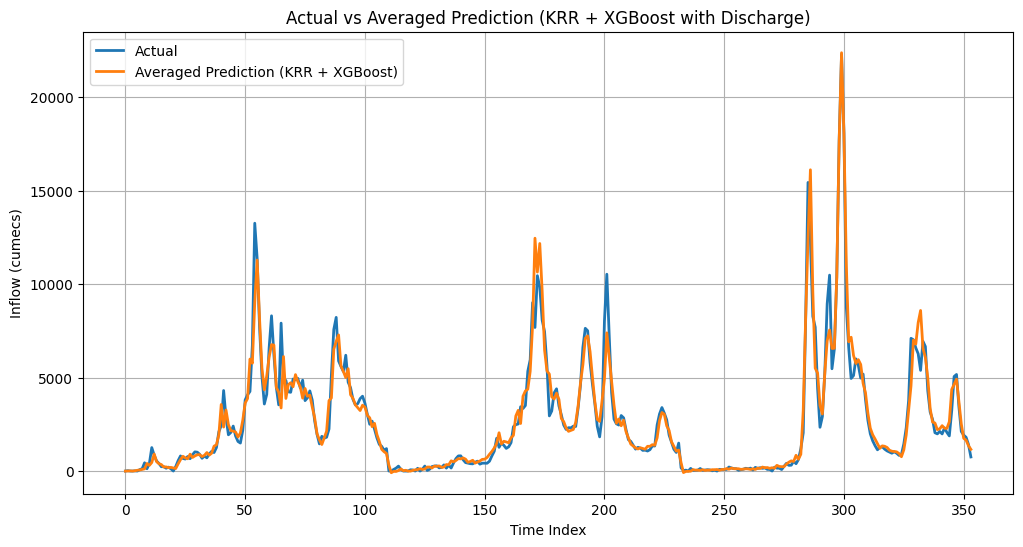

In [69]:
# --- Compute the average prediction ---
avg_pred = (y_pred_krr + y_pred_xgb_discharge) / 2

# --- Evaluate metrics for the averaged model ---
metrics_avg = calculate_all_metrics(y_test_discharge, avg_pred)
print("Averaged Model Metrics (KRR + XGBoost with Discharge):", metrics_avg)

# --- Tabular Comparison of Metrics: KRR vs AVG vs XGBoost with Discharge ---
metrics_compare = pd.DataFrame({
    'Metric': ['NSE', 'RMSE', 'R2', 'KGE', 'EVOL', 'PE', 'TPE', 'CV_Score'],
    'KRR': [
        model_results['KRR'].get('NSE'),
        model_results['KRR'].get('RMSE'),
        model_results['KRR'].get('R2'),
        model_results['KRR'].get('KGE'),
        model_results['KRR'].get('EVOL'),
        model_results['KRR'].get('PE'),
        model_results['KRR'].get('TPE'),
        model_results['KRR'].get('CV_Score')
    ],
    'AVG (KRR+XGB)': [
        metrics_avg.get('NSE'),
        metrics_avg.get('RMSE'),
        metrics_avg.get('R2'),
        metrics_avg.get('KGE'),
        metrics_avg.get('EVOL'),
        metrics_avg.get('PE'),
        metrics_avg.get('TPE'),
        metrics_avg.get('CV_Score')
    ],
    'XGBoost with Discharge': [
        metrics_xgb_with_discharge.get('NSE'),
        metrics_xgb_with_discharge.get('RMSE'),
        metrics_xgb_with_discharge.get('R2'),
        metrics_xgb_with_discharge.get('KGE'),
        metrics_xgb_with_discharge.get('EVOL'),
        metrics_xgb_with_discharge.get('PE'),
        metrics_xgb_with_discharge.get('TPE'),
        metrics_xgb_with_discharge.get('CV_Score')
    ]
})
print("Tabular Comparison of KRR vs AVG (KRR+XGB) vs XGBoost with Discharge:")
print(metrics_compare.to_string(index=False))

# --- Plot actual vs averaged prediction ---
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_test_discharge), label='Actual', linewidth=2)
plt.plot(avg_pred, label='Averaged Prediction (KRR + XGBoost)', linewidth=2)
plt.title('Actual vs Averaged Prediction (KRR + XGBoost with Discharge)')
plt.xlabel('Time Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.grid(True)

9. Comparative Analysis: KRR vs AVG vs XGBoost with Discharge


Tabular comparison of metrics,Overlayed actual vs predicted plots, scatter plots, residuals, deflection statistics, QQ plots, and boxplots.
 Deflection from Origin Statistics




In [ ]:
# --- 1. Tabular Comparison of Metrics: KRR vs AVG vs XGBoost with Discharge ---
metrics_compare = pd.DataFrame({
    'Metric': ['NSE', 'RMSE', 'R2', 'KGE', 'EVOL', 'PE', 'TPE', 'CV_Score'],
    'KRR': [
        model_results['KRR'].get('NSE'),
        model_results['KRR'].get('RMSE'),
        model_results['KRR'].get('R2'),
        model_results['KRR'].get('KGE'),
        model_results['KRR'].get('EVOL'),
        model_results['KRR'].get('PE'),
        model_results['KRR'].get('TPE'),
        model_results['KRR'].get('CV_Score')
    ],
    'AVG (KRR+XGB)': [
        metrics_avg.get('NSE'),
        metrics_avg.get('RMSE'),
        metrics_avg.get('R2'),
        metrics_avg.get('KGE'),
        metrics_avg.get('EVOL'),
        metrics_avg.get('PE'),
        metrics_avg.get('TPE'),
        metrics_avg.get('CV_Score')
    ],
    'XGBoost with Discharge': [
        metrics_xgb_with_discharge.get('NSE'),
        metrics_xgb_with_discharge.get('RMSE'),
        metrics_xgb_with_discharge.get('R2'),
        metrics_xgb_with_discharge.get('KGE'),
        metrics_xgb_with_discharge.get('EVOL'),
        metrics_xgb_with_discharge.get('PE'),
        metrics_xgb_with_discharge.get('TPE'),
        metrics_xgb_with_discharge.get('CV_Score')
    ]
})
print("Tabular Comparison of KRR vs AVG (KRR+XGB) vs XGBoost with Discharge:")
print(metrics_compare.to_string(index=False))

# --- 2. Overlayed Actual vs Predicted Plots ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_discharge.values, label='Actual', color='black', linewidth=2)
plt.plot(y_pred_xgb_discharge, label='XGBoost with Discharge', color='tab:blue', alpha=0.8)
plt.plot(y_pred_krr, label='KRR', color='tab:orange', alpha=0.8)
plt.plot(avg_pred, label='AVG (KRR+XGB)', color='tab:green', linestyle='--', alpha=0.9)
plt.title('Actual vs Predicted: KRR vs XGBoost with Discharge vs AVG')
plt.xlabel('Test Sample Index')
plt.ylabel('Inflow (cumecs)')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Scatter Plot: Observed vs Predicted ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test_discharge, y_pred_xgb_discharge, alpha=0.5, label='XGBoost with Discharge')
plt.scatter(y_test_discharge, y_pred_krr, alpha=0.5, label='KRR')
plt.scatter(y_test_discharge, avg_pred, alpha=0.5, label='AVG (KRR+XGB)')
plt.plot([y_test_discharge.min(), y_test_discharge.max()], [y_test_discharge.min(), y_test_discharge.max()], 'k--', lw=2)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted Scatter')
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Residuals Over Time ---
plt.figure(figsize=(14, 4))
plt.plot(y_test_discharge.values - y_pred_xgb_discharge, label='Residuals: XGBoost with Discharge', color='tab:blue')
plt.plot(y_test_discharge.values - y_pred_krr, label='Residuals: KRR', color='tab:orange')
plt.plot(y_test_discharge.values - avg_pred, label='Residuals: AVG (KRR+XGB)', color='tab:green')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Test Sample Index')
plt.ylabel('Observed - Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Deflection from Origin (Scatter of Residuals vs Predicted) ---
plt.figure(figsize=(6, 5))
plt.scatter(y_pred_xgb_discharge, y_test_discharge - y_pred_xgb_discharge, alpha=0.5, label='XGBoost with Discharge')
plt.scatter(y_pred_krr, y_test_discharge - y_pred_krr, alpha=0.5, label='KRR')
plt.scatter(avg_pred, y_test_discharge - avg_pred, alpha=0.5, label='AVG (KRR+XGB)')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Inflow (cumecs)')
plt.ylabel('Residual (Observed - Predicted)')
plt.title('Deflection from Origin: Residuals vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# --- 6. QQ Plots for Residuals ---
import scipy.stats as stats
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
stats.probplot(y_test_discharge - y_pred_xgb_discharge, dist="norm", plot=axes[0])
axes[0].set_title('QQ Plot Residuals: XGBoost with Discharge')
stats.probplot(y_test_discharge - y_pred_krr, dist="norm", plot=axes[1])
axes[1].set_title('QQ Plot Residuals: KRR')
stats.probplot(y_test_discharge - avg_pred, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot Residuals: AVG (KRR+XGB)')
plt.tight_layout()
plt.show()

# --- 7. Boxplot of Residuals ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame({
    'XGBoost+Discharge': y_test_discharge - y_pred_xgb_discharge,
    'KRR': y_test_discharge - y_pred_krr,
    'AVG (KRR+XGB)': y_test_discharge - avg_pred
}))
plt.title('Residuals Distribution')
plt.ylabel('Residual (Observed - Predicted)')
plt.tight_layout()
plt.show()

# --- 8. Deflection Statistics ---
deflection_stats = pd.DataFrame({
    'Model': ['XGBoost with Discharge', 'KRR', 'AVG (KRR+XGB)'],
    'Mean Residual': [
        np.mean(y_test_discharge - y_pred_xgb_discharge),
        np.mean(y_test_discharge - y_pred_krr),
        np.mean(y_test_discharge - avg_pred)
    ],
    'Std Residual': [
        np.std(y_test_discharge - y_pred_xgb_discharge),
        np.std(y_test_discharge - y_pred_krr),
        np.std(y_test_discharge - avg_pred)
    ],
    'Max Residual': [
        np.max(np.abs(y_test_discharge - y_pred_xgb_discharge)),
        np.max(np.abs(y_test_discharge - y_pred_krr)),
        np.max(np.abs(y_test_discharge - avg_pred))
    ]
})
print("\nDeflection from Origin Statistics:")
print(deflection_stats.to_string(index=False))